# Neural Networks Extended Project

### Edward Monbiot

<a id='top'></a>
## Table of Contents

1. [Section 1: Data Loading](#section1)

2. [Section 2: Data Preprocessing](#section2)

3. [Section 3: Neural Networks Models-SK Learn](#section3)

4. [Section 4: Neural Network Models - Keras](#section4)

5. [Section 5: Kaggle Submission](#section5)

---------



<a id='section1'></a>
## Section 1 Data Loading

In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from category_encoders import BinaryEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, roc_auc_score, mean_squared_error, mean_absolute_error, r2_score, median_absolute_error, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import IsolationForest
import missingno as msno
# from scipy.stats import chi2_contingency
from datetime import datetime
from tqdm import tqdm
import seaborn as sns
import category_encoders as ce
import pickle
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neural_network import MLPClassifier, MLPRegressor

### Load the train, test datasets & metadata sets

In [143]:
#train 
df_train = pd.read_csv(r"C:\Users\Edward Monbiot\Documents\dl24-probability-of-death-with-k-nn\mimic_train.csv")

#test
df_test = pd.read_csv(r"C:\Users\Edward Monbiot\Documents\mimic_test_los.csv")


print(len(df_train['hadm_id'].unique()))

19749


In [144]:
metadata_df = pd.read_csv(r"C:\Users\Edward Monbiot\Documents\dl24-probability-of-death-with-k-nn\extra_data\MIMIC_diagnoses.csv")

display(metadata_df)
print(len(metadata_df['HADM_ID'].unique()))

,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,256,108811,1.0,53240
1,256,108811,2.0,41071
2,256,108811,3.0,53560
3,256,108811,4.0,40390
4,256,108811,5.0,5859
...,...,...,...,...
651042,65535,178280,5.0,5119
651043,65535,178280,6.0,5990
651044,65535,178280,7.0,0414
651045,65535,178280,8.0,25000


58976


In [145]:
id_cols = ['subject_id', 'hadm_id', 'icustay_id']
df_output = df_test.copy()

<a id='section2'></a>
# Section 2: Data Preprocessing

### 2.1 Metadata Merging & Validation

In [146]:
# Aggregate comorbidities data
comorbidities = metadata_df.groupby('HADM_ID').agg(
    DIAGNOSIS_COUNT=('ICD9_CODE', 'nunique'),  # Count of unique ICD9 codes
    ICD9_CODE_LIST=('ICD9_CODE', lambda x: list(x.unique()))  # List of unique ICD9 codes
).reset_index()

# Merge the aggregated data with the training and test datasets
df_train = pd.merge(df_train, comorbidities, left_on='hadm_id', right_on='HADM_ID',how='left').drop(columns='HADM_ID')
df_test = pd.merge(df_test, comorbidities, left_on='hadm_id', right_on='HADM_ID',how='left').drop(columns='HADM_ID')

# Print statistics for DIAGNOSIS_COUNT in the training set
print(max(df_train['DIAGNOSIS_COUNT']))
print(df_train['DIAGNOSIS_COUNT'].describe())

# Prepare columns for target encoding
target_encoder_cols = []

# For each possible position in the ICD9_CODE_LIST, create a new column in the training and test sets
for i in range(1, 40):
    df_train[f'code{i}'] = df_train['ICD9_CODE_LIST'].apply(lambda x: x[i-1] if len(x) > i-1 else None)
    df_test[f'code{i}'] = df_test['ICD9_CODE_LIST'].apply(lambda x: x[i-1] if len(x) > i-1 else None)
    target_encoder_cols.append(f'code{i}')

# Create a list of columns that are out of the original ICD9_CODE_LIST
cols_out_of_list = target_encoder_cols.copy()
cols_out_of_list.append('ICD9_CODE_LIST')

# Print the lists of columns for target encoding and additional columns
print(target_encoder_cols)
print(cols_out_of_list)


39
count    20885.000000
mean        14.836916
std          7.299555
min          1.000000
25%          9.000000
50%         14.000000
75%         19.000000
max         39.000000
Name: DIAGNOSIS_COUNT, dtype: float64
['code1', 'code2', 'code3', 'code4', 'code5', 'code6', 'code7', 'code8', 'code9', 'code10', 'code11', 'code12', 'code13', 'code14', 'code15', 'code16', 'code17', 'code18', 'code19', 'code20', 'code21', 'code22', 'code23', 'code24', 'code25', 'code26', 'code27', 'code28', 'code29', 'code30', 'code31', 'code32', 'code33', 'code34', 'code35', 'code36', 'code37', 'code38', 'code39']
['code1', 'code2', 'code3', 'code4', 'code5', 'code6', 'code7', 'code8', 'code9', 'code10', 'code11', 'code12', 'code13', 'code14', 'code15', 'code16', 'code17', 'code18', 'code19', 'code20', 'code21', 'code22', 'code23', 'code24', 'code25', 'code26', 'code27', 'code28', 'code29', 'code30', 'code31', 'code32', 'code33', 'code34', 'code35', 'code36', 'code37', 'code38', 'code39', 'ICD9_CODE_LIST']


In [147]:
# Display the first few rows of the training dataset
display(df_train)

# Display the first few rows of the test dataset
display(df_test)

# Specify the target variable for prediction
target = 'LOS'

,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,...,code30,code31,code32,code33,code34,code35,code36,code37,code38,code39
0,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,...,None,None,None,None,None,None,None,None,None,None
1,0,76908,126136,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,...,None,None,None,None,None,None,None,None,None,None
2,0,95798,136645,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,...,None,None,None,None,None,None,None,None,None,None
3,0,40708,102505,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,...,None,None,None,None,None,None,None,None,None,None
4,0,28424,127337,225281,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20880,0,28043,135417,244530,65.0,92.0,78.500000,60.0,160.0,110.976190,...,E8798,None,None,None,None,None,None,None,None,None
20881,0,87605,191007,216116,74.0,112.0,89.156250,100.0,150.0,123.272727,...,None,None,None,None,None,None,None,None,None,None
20882,0,47492,152608,274507,58.0,97.0,76.933333,94.0,131.0,112.037037,...,None,None,None,None,None,None,None,None,None,None
20883,0,62946,191485,225930,59.0,102.0,81.844444,96.0,150.0,123.837209,...,None,None,None,None,None,None,None,None,None,None


,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,...,code30,code31,code32,code33,code34,code35,code36,code37,code38,code39
0,64058,146725,208169,58.0,90.0,85.244898,77.0,153.0,98.490909,40.0,...,None,None,None,None,None,None,None,None,None,None
1,55871,108789,251754,91.0,145.0,115.055556,73.0,143.0,101.210526,42.0,...,None,None,None,None,None,None,None,None,None,None
2,42892,139885,242171,106.0,132.0,117.750000,93.0,137.0,116.222222,51.0,...,None,None,None,None,None,None,None,None,None,None
3,66629,173017,263035,72.0,105.0,83.627119,72.0,168.0,126.981818,39.0,...,None,None,None,None,None,None,None,None,None,None
4,79851,171573,279388,85.0,124.0,98.600000,86.0,144.0,110.666667,52.0,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5216,28941,107962,278087,63.0,131.0,97.130435,108.0,140.0,122.631579,49.0,...,4589,496,7823,78830,53081,6983,71590,6961,27800,2809
5217,27436,112243,266914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
5218,44232,156430,213413,74.0,91.0,81.488372,117.0,171.0,143.395349,48.0,...,None,None,None,None,None,None,None,None,None,None
5219,76544,148900,286384,70.0,89.0,80.276596,68.0,137.0,110.680851,42.0,...,None,None,None,None,None,None,None,None,None,None


### 2.2 Missing Data Check

In [148]:
def analyze_missing_data(df_train, df_test, cols_to_exclude):
    # Exclude specified columns from the analysis
    df_train_analysis = df_train.drop(columns=cols_to_exclude, errors='ignore')
    df_test_analysis = df_test.drop(columns=cols_to_exclude, errors='ignore')

    # Calculate missing data for training and test datasets
    missing_train = df_train_analysis.isnull().sum()
    missing_test = df_test_analysis.isnull().sum()

    # Calculate percentages
    missing_train_percent = (missing_train / len(df_train_analysis)) * 100
    missing_test_percent = (missing_test / len(df_test_analysis)) * 100

    # Create DataFrame
    missing_data = pd.DataFrame({
        'Missing_Train': missing_train,
        'Missing_Percent_Train (%)': missing_train_percent,
        'Missing_Test': missing_test,
        'Missing_Percent_Test (%)': missing_test_percent
    })

    # Sort and format the DataFrame
    missing_data = missing_data.sort_values(by='Missing_Percent_Train (%)', ascending=False)
    missing_data = missing_data.round(2)  # Rounds the percentages for better readability

    # Filter out columns with no missing data in both train and test datasets
    missing_data = missing_data[(missing_data['Missing_Percent_Train (%)'] > 0) | 
                                (missing_data['Missing_Percent_Test (%)'] > 0)]

    return missing_data

# Call the function with your datasets and exclude columns listed in cols_out_of_list
missing_data_analysis = analyze_missing_data(df_train, df_test, cols_out_of_list)
missing_data_analysis


,Missing_Train,Missing_Percent_Train (%),Missing_Test,Missing_Percent_Test (%)
DEATHTIME,18540,88.77,NaN,NaN
DOD,13511,64.69,NaN,NaN
TempC_Min,2497,11.96,638.0,12.22
TempC_Mean,2497,11.96,638.0,12.22
TempC_Max,2497,11.96,638.0,12.22
DiasBP_Max,2209,10.58,552.0,10.57
DiasBP_Mean,2209,10.58,552.0,10.57
DiasBP_Min,2209,10.58,552.0,10.57
SysBP_Min,2208,10.57,551.0,10.55
SysBP_Mean,2208,10.57,551.0,10.55


The msno.matrix visualization shows the missingness pattern of a dataset.

<Axes: >

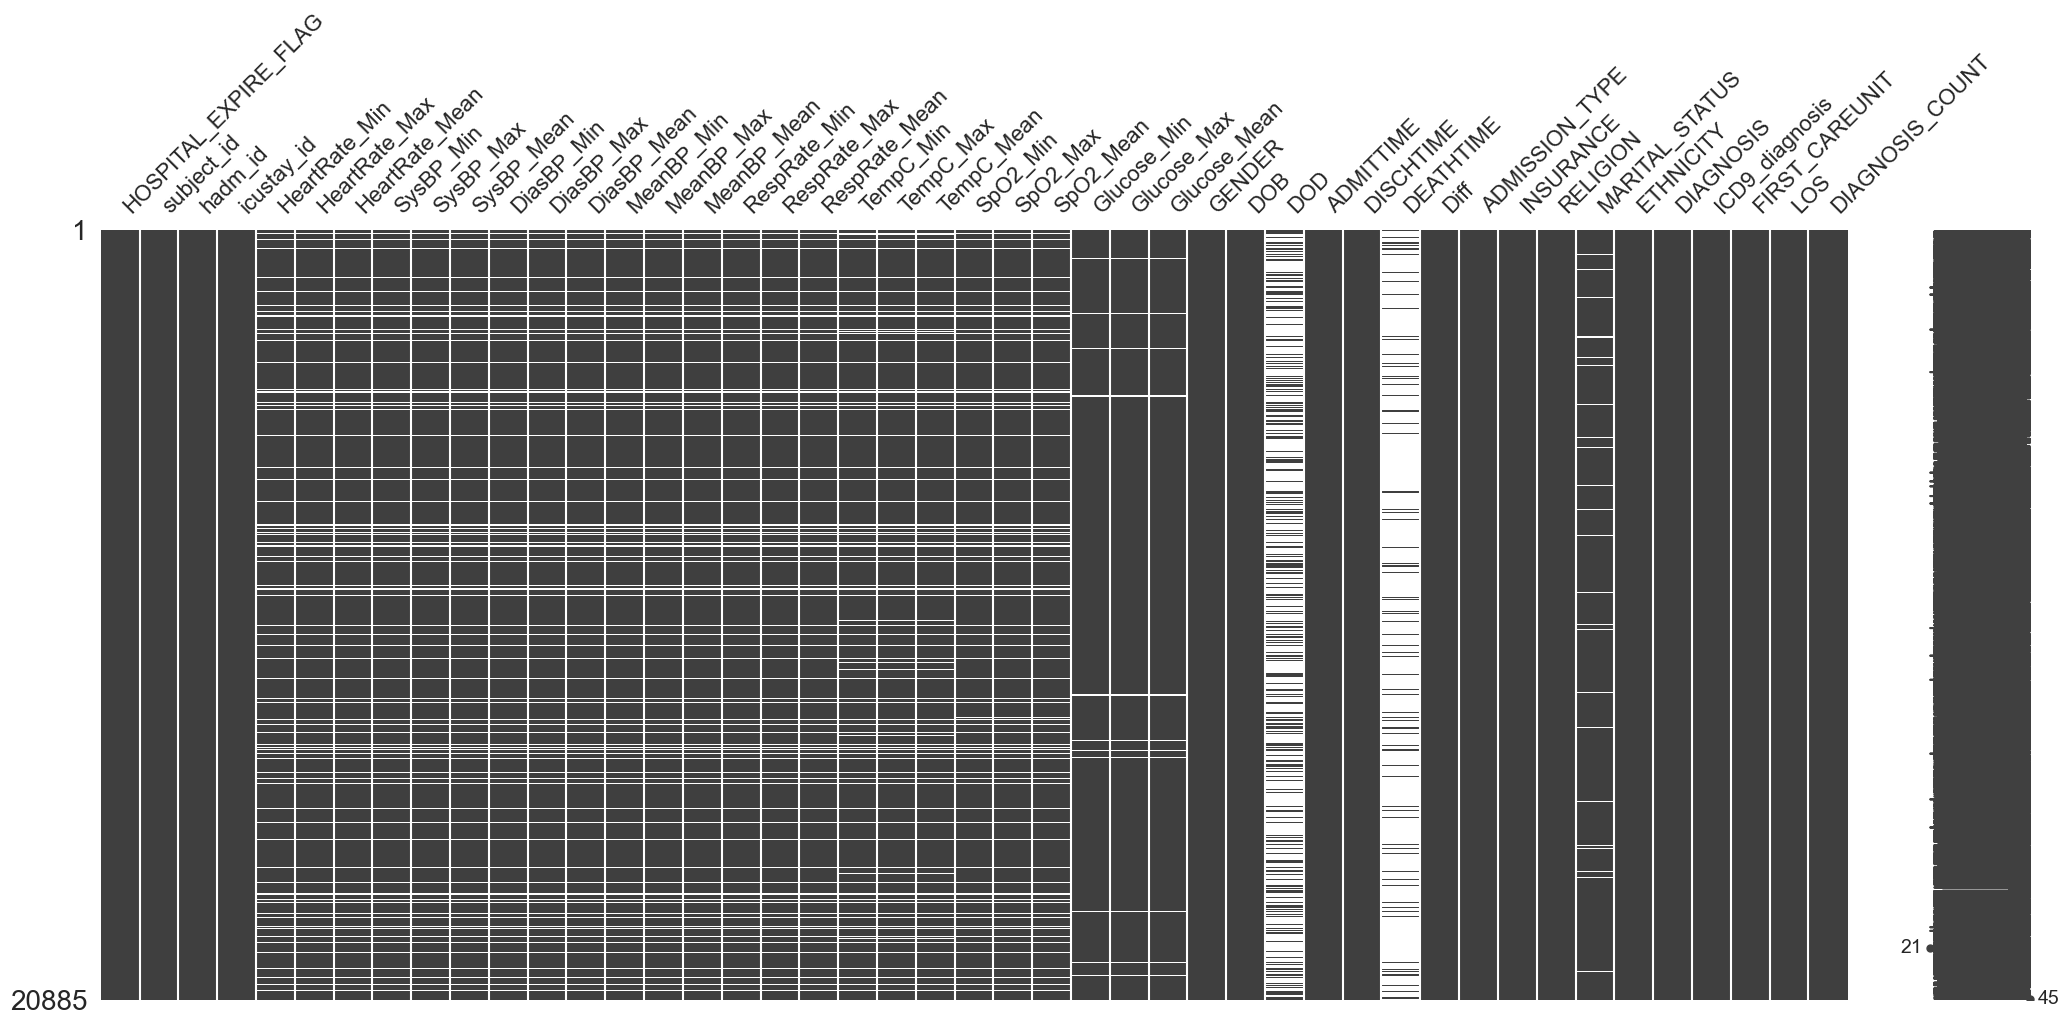

In [149]:
df_msno_train = df_train.drop(columns=cols_out_of_list)

# Visualize the missing data with msno.matrix on the subset
msno.matrix(df_msno_train)


Matrix shows lots of missing values for Deathtime and quite a few missing for the medical columns, this will be taken into the account in preprocessing

<Axes: >

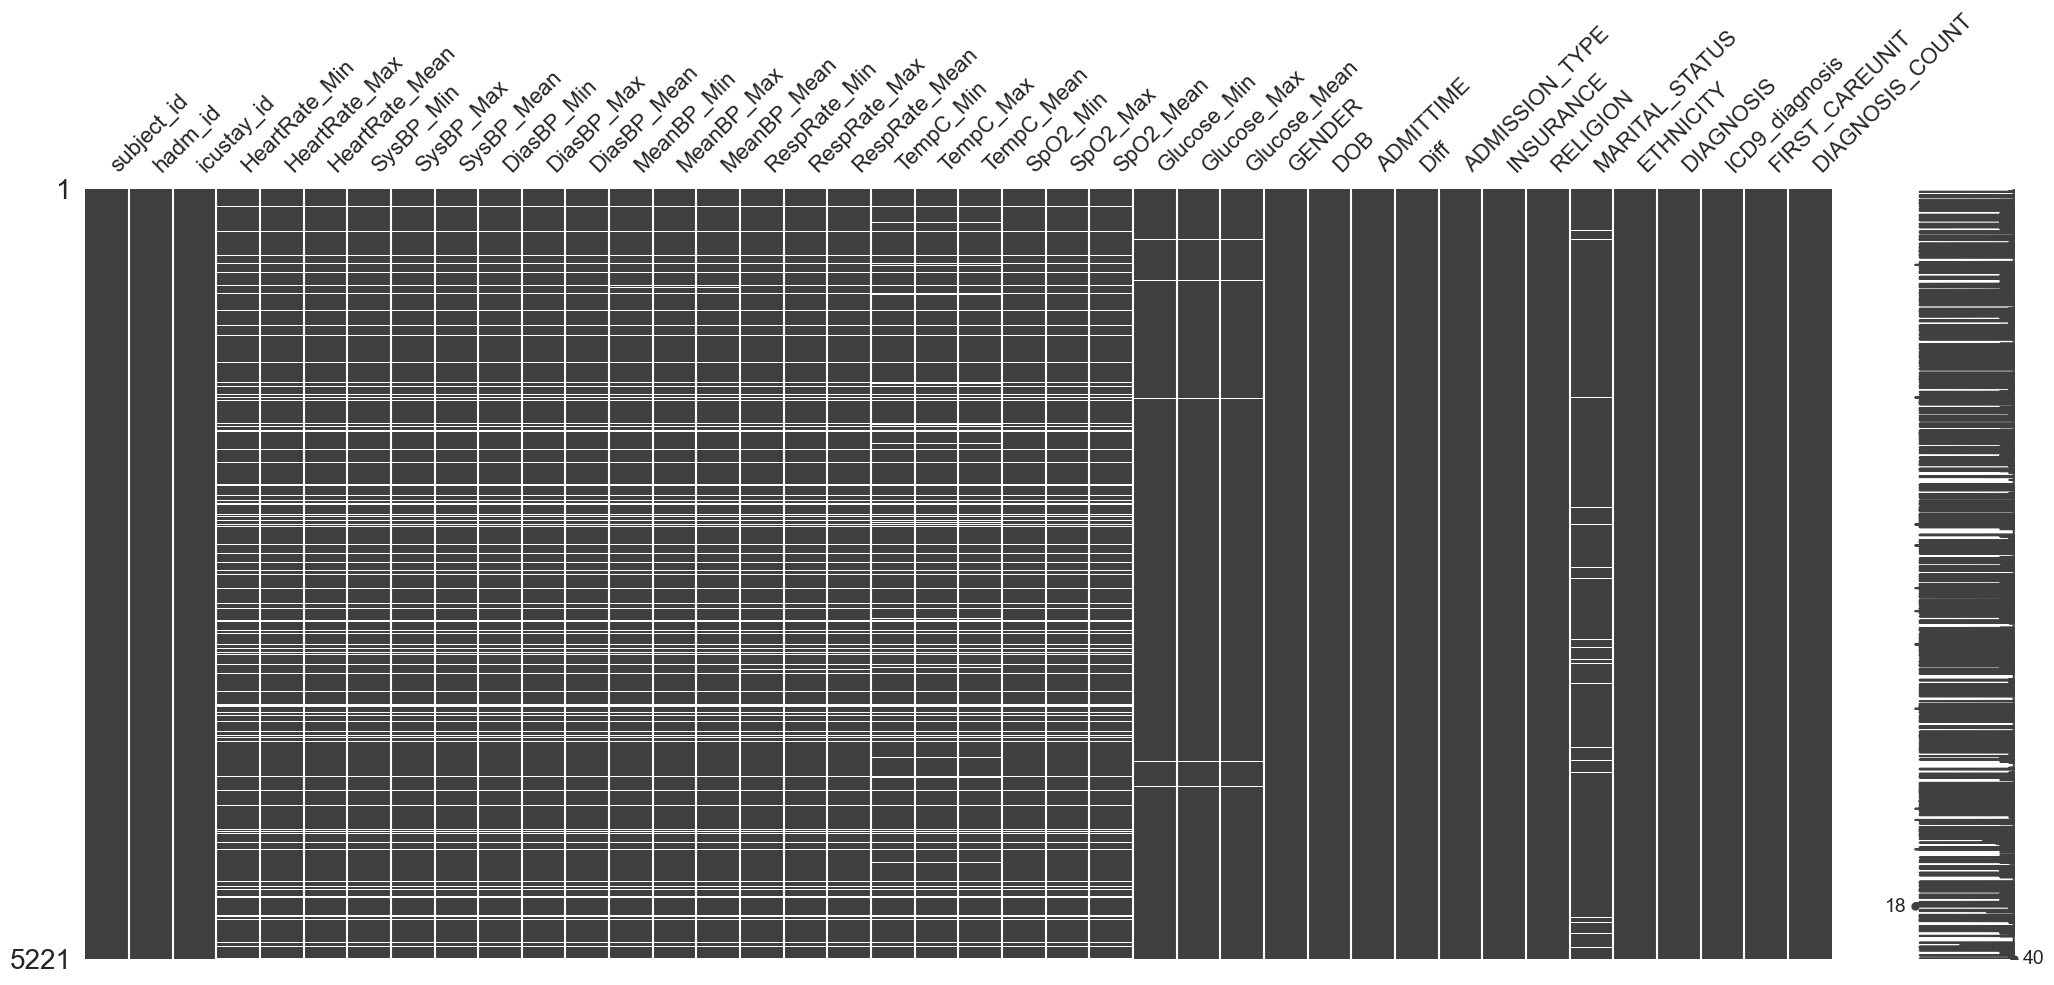

In [150]:
df_msno_test = df_test.drop(columns=cols_out_of_list)

# Visualize the missing data with msno.matrix on the subset
msno.matrix(df_msno_test)

Test data shows a more complete picture, but missing features as well in the medical columns 

In [151]:
display(df_train.info())
display(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20885 entries, 0 to 20884
Data columns (total 85 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   HOSPITAL_EXPIRE_FLAG  20885 non-null  int64  
 1   subject_id            20885 non-null  int64  
 2   hadm_id               20885 non-null  int64  
 3   icustay_id            20885 non-null  int64  
 4   HeartRate_Min         18698 non-null  float64
 5   HeartRate_Max         18698 non-null  float64
 6   HeartRate_Mean        18698 non-null  float64
 7   SysBP_Min             18677 non-null  float64
 8   SysBP_Max             18677 non-null  float64
 9   SysBP_Mean            18677 non-null  float64
 10  DiasBP_Min            18676 non-null  float64
 11  DiasBP_Max            18676 non-null  float64
 12  DiasBP_Mean           18676 non-null  float64
 13  MeanBP_Min            18699 non-null  float64
 14  MeanBP_Max            18699 non-null  float64
 15  MeanBP_Mean        

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5221 entries, 0 to 5220
Data columns (total 80 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   subject_id       5221 non-null   int64  
 1   hadm_id          5221 non-null   int64  
 2   icustay_id       5221 non-null   int64  
 3   HeartRate_Min    4676 non-null   float64
 4   HeartRate_Max    4676 non-null   float64
 5   HeartRate_Mean   4676 non-null   float64
 6   SysBP_Min        4670 non-null   float64
 7   SysBP_Max        4670 non-null   float64
 8   SysBP_Mean       4670 non-null   float64
 9   DiasBP_Min       4669 non-null   float64
 10  DiasBP_Max       4669 non-null   float64
 11  DiasBP_Mean      4669 non-null   float64
 12  MeanBP_Min       4674 non-null   float64
 13  MeanBP_Max       4674 non-null   float64
 14  MeanBP_Mean      4674 non-null   float64
 15  RespRate_Min     4675 non-null   float64
 16  RespRate_Max     4675 non-null   float64
 17  RespRate_Mean 

None

### 2.3 Age Preprocessing

In [152]:
# Convert 'ADMITTIME' and 'DOB' columns to datetime in both training and test sets
df_train['ADMITTIME'] = pd.to_datetime(df_train['ADMITTIME'])
df_train['DOB'] = pd.to_datetime(df_train['DOB'])
df_test['ADMITTIME'] = pd.to_datetime(df_test['ADMITTIME'])
df_test['DOB'] = pd.to_datetime(df_test['DOB'])

# Adjust 'ADMITTIME' and 'DOB' by a 'Diff' column representing days, in both datasets
df_train['ADMITTIME'] += pd.to_timedelta(df_train['Diff'], unit='D')
df_train['DOB'] += pd.to_timedelta(df_train['Diff'], unit='D')
df_test['ADMITTIME'] += pd.to_timedelta(df_test['Diff'], unit='D')
df_test['DOB'] += pd.to_timedelta(df_test['Diff'], unit='D')

# Print the distribution of years in the 'ADMITTIME' column with a descriptive message
print("Distribution of admission years in the training dataset:")
print(df_train['ADMITTIME'].dt.year.value_counts())

# Count the number of rows where 'DOB' year is before 1900 and print with a descriptive message
dob_pre_1900_count = df_train[df_train['DOB'].dt.year < 1900]['DOB'].dt.year.value_counts().sum()
print(f"Number of patients with DOB before 1900: {dob_pre_1900_count}")

# Print the value counts of 'DOB' year where the year is before 1900 with a descriptive message
print("Value counts of DOB years before 1900:")
print(df_train[df_train['DOB'].dt.year < 1900]['DOB'].dt.year.value_counts())

# Replace 'DOB' with NaN where the year is before 1900 in both datasets to handle potential data privacy methods
df_train.loc[df_train['DOB'].dt.year < 1900, 'DOB'] = np.nan
df_test.loc[df_test['DOB'].dt.year < 1900, 'DOB'] = np.nan



Distribution of admission years in the training dataset:


ADMITTIME
2008    5242
2009    4203
2010    4150
2011    4113
2012    3170
2007       7
Name: count, dtype: int64
Number of patients with DOB before 1900: 1107
Value counts of DOB years before 1900:
DOB
1708    286
1709    198
1710    175
1711    169
1712    133
1707     50
1702     24
1703     23
1706     18
1705     17
1704     11
1701      3
Name: count, dtype: int64


Individuals over the age of 89 are assigned placeholder birth years before 1900, maintaining a maximum reported age of 89. The dataset starts in 2007, ensuring the age cutoff does not omit any patients who entered the ICU at age 89.

In [153]:
# Calculate 'AGE' from 'ADMITTIME' and 'DOB', considering leap years
df_train['AGE'] = round((df_train['ADMITTIME'] - df_train['DOB']).dt.days / 365.25)
df_test['AGE'] = round((df_test['ADMITTIME'] - df_test['DOB']).dt.days / 365.25)

# Impute an age of 93 for patients older than 89 whose 'DOB' is set before 1900
df_train.loc[df_train['AGE'].isna(), 'AGE'] = 93.0
df_test.loc[df_test['AGE'].isna(), 'AGE'] = 93.0

# Display the 'AGE' column from the training set to verify the imputation
print("AGE column after imputation in the training set:")
display(df_train['AGE'])

# Generate and print descriptive statistics for the 'AGE' column in both datasets
print("\nDescriptive statistics for AGE in the training set:")
display(df_train['AGE'].describe())

print("\nDescriptive statistics for AGE in the test set:")
display(df_test['AGE'].describe())


AGE column after imputation in the training set:


0        70.0
1        42.0
2        68.0
3        75.0
4        79.0
         ... 
20880    88.0
20881    66.0
20882    63.0
20883    93.0
20884    46.0
Name: AGE, Length: 20885, dtype: float64


Descriptive statistics for AGE in the training set:


count    20885.000000
mean        64.350347
std         17.381877
min         15.000000
25%         53.000000
50%         66.000000
75%         78.000000
max         93.000000
Name: AGE, dtype: float64


Descriptive statistics for AGE in the test set:


count    5221.000000
mean       64.810764
std        17.107341
min        15.000000
25%        54.000000
50%        66.000000
75%        78.000000
max        93.000000
Name: AGE, dtype: float64

To address the data gap for patients older than 89 without real ages, I imputed an estimated average age of 93, reflecting that this group is certainly older but with a conservative skew towards the lower end of the 90-100 range. This approach aims to capture the health impact of advanced age without disproportionately influencing the statistical analysis of age-related risks.

c:\Users\Edward Monbiot\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Edward Monbiot\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


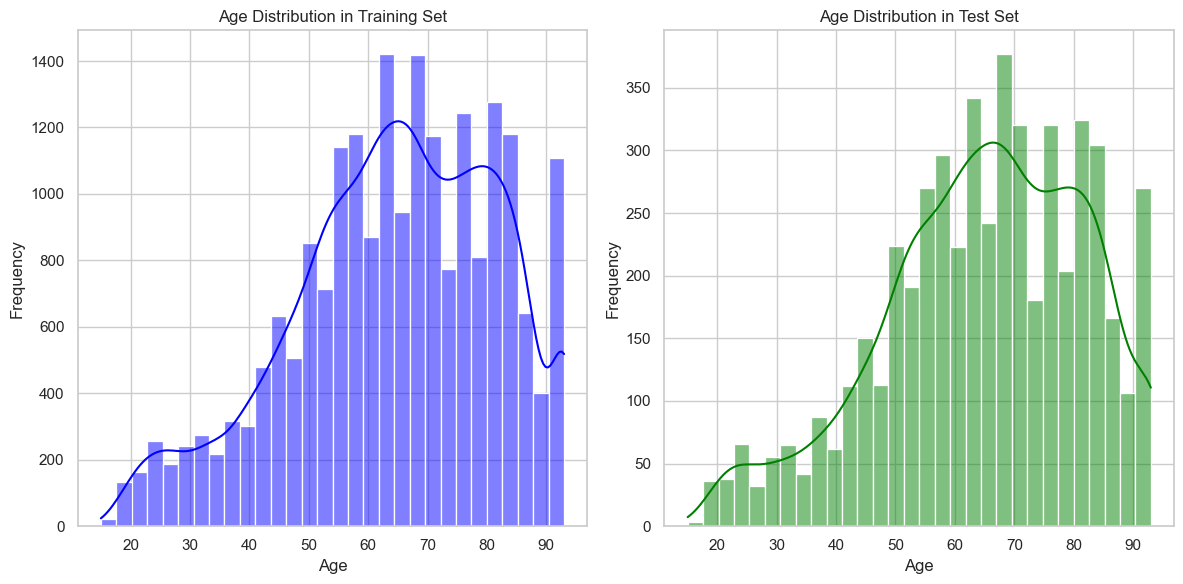

In [154]:
# Set the style for the histograms to visualize the distribution of the AGE data
sns.set(style="whitegrid")

# Creating histograms with a KDE line
plt.figure(figsize=(12, 6))

# Histogram with KDE for the training set
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.histplot(df_train['AGE'], bins=30, kde=True, color='blue')
plt.title('Age Distribution in Training Set')
plt.xlabel('Age')
plt.ylabel('Frequency')

# Histogram with KDE for the test set
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.histplot(df_test['AGE'], bins=30, kde=True, color='green')  # Corrected to df_test
plt.title('Age Distribution in Test Set')
plt.xlabel('Age')
plt.ylabel('Frequency')

# Show the plot
plt.tight_layout()
plt.show()


The histograms for the train and test sets show a cutoff at 89 years with no data beyond this age, indicating that the preprocessing step to impute ages over 89 has been applied. There is a noticeable spike at the 89-year mark in both training and test sets, reflecting the aggregation of all older ages into this single value.

In [155]:
# former age imputing logic

"""
# do the age calculations
df_train['DOB'] = pd.to_datetime(df_train['DOB']).dt.date
df_train['ADMITDATE'] = pd.to_datetime(df_train['ADMITTIME']).dt.date
X_test['DOB'] = pd.to_datetime(X_test['DOB']).dt.date
X_test['ADMITDATE'] = pd.to_datetime(X_test['ADMITTIME']).dt.date

# Calculating AGE
df_train['AGE'] = df_train.apply(lambda x: round((x['ADMITDATE'] - x['DOB']).days / 365, 0), axis=1)
X_test['AGE'] = X_test.apply(lambda x: round((x['ADMITDATE'] - x['DOB']).days / 365, 0), axis=1)

# Dropping the now redundant date columns
df_train = df_train.drop(['DOB', 'ADMITDATE'], axis=1)
X_test = X_test.drop(['DOB', 'ADMITDATE'], axis=1)

# Print min and max ages for verification
print('For the training set; [min,max]:', min(df_train['AGE']), max(df_train['AGE']))
print('For the test set; [min,max]:', min(X_test['AGE']), max(X_test['AGE']))

# Set AGE > 100 to NaN
df_train.loc[df_train['AGE'] > 100, 'AGE'] = np.nan
X_test.loc[X_test['AGE'] > 100, 'AGE'] = np.nan

# Calculate the median age of individuals aged 100 or less
median_age_train = df_train.loc[df_train['AGE'] <= 100, 'AGE'].median()
median_age_test = X_test.loc[X_test['AGE'] <= 100, 'AGE'].median()

# Impute NaN values with the median age
df_train['AGE'].fillna(median_age_train, inplace=True)
X_test['AGE'].fillna(median_age_test, inplace=True)

# Print min and max ages for verification
print('For the training set; [min,max]:', min(df_train['AGE']), max(df_train['AGE']))
print('For the test set; [min,max]:', min(X_test['AGE']), max(X_test['AGE']))

# Create age groups by defining the bins and labels 
bins = [0, 17, 64, float('inf')]  # float('inf') ensures that all ages above 64 are included in the senior category
labels = ['child', 'adult', 'senior']

# Create the binned age group category for both training and test datasets
df_train['age_group'] = pd.cut(df_train['AGE'], bins=bins, labels=labels, right=False)
X_test['age_group'] = pd.cut(X_test['AGE'], bins=bins, labels=labels, right=False)

# Verifying the changes
print(df_train[['AGE', 'age_group']].head())
print(X_test[['AGE', 'age_group']].head())
"""

"\n# do the age calculations\ndf_train['DOB'] = pd.to_datetime(df_train['DOB']).dt.date\ndf_train['ADMITDATE'] = pd.to_datetime(df_train['ADMITTIME']).dt.date\nX_test['DOB'] = pd.to_datetime(X_test['DOB']).dt.date\nX_test['ADMITDATE'] = pd.to_datetime(X_test['ADMITTIME']).dt.date\n\n# Calculating AGE\ndf_train['AGE'] = df_train.apply(lambda x: round((x['ADMITDATE'] - x['DOB']).days / 365, 0), axis=1)\nX_test['AGE'] = X_test.apply(lambda x: round((x['ADMITDATE'] - x['DOB']).days / 365, 0), axis=1)\n\n# Dropping the now redundant date columns\ndf_train = df_train.drop(['DOB', 'ADMITDATE'], axis=1)\nX_test = X_test.drop(['DOB', 'ADMITDATE'], axis=1)\n\n# Print min and max ages for verification\nprint('For the training set; [min,max]:', min(df_train['AGE']), max(df_train['AGE']))\nprint('For the test set; [min,max]:', min(X_test['AGE']), max(X_test['AGE']))\n\n# Set AGE > 100 to NaN\ndf_train.loc[df_train['AGE'] > 100, 'AGE'] = np.nan\nX_test.loc[X_test['AGE'] > 100, 'AGE'] = np.nan\n\n# C

### 2.4 ICU Time Calcuations 

In [156]:
# Extract the hour of admission from 'ADMITTIME' and create a new column 'ADMIT_HOUR'
df_train['ADMIT_HOUR'] = df_train['ADMITTIME'].dt.hour
df_test['ADMIT_HOUR'] = df_test['ADMITTIME'].dt.hour

In [157]:
# Create subsets from the training and test datasets with only necessary columns for ICU stay counts
df_train_count = df_train[['subject_id', 'ADMITTIME', 'icustay_id']].copy()
df_test_count = df_test[['subject_id', 'ADMITTIME', 'icustay_id']].copy()

# Sort the data by 'subject_id' and 'ADMITTIME' to properly sequence the ICU stays
df_train_count = df_train_count.sort_values(by=['subject_id', 'ADMITTIME'])
df_test_count = df_test_count.sort_values(by=['subject_id', 'ADMITTIME'])

# Calculate the cumulative count of ICU stays per patient to determine the number of previous stays
df_train_count['previous_icu_stays'] = df_train_count.groupby('subject_id').cumcount()
df_test_count['previous_icu_stays'] = df_test_count.groupby('subject_id').cumcount()

# Merge the cumulative count of ICU stays back into the original training and test datasets
df_train = pd.merge(df_train, df_train_count[['icustay_id', 'previous_icu_stays']], on='icustay_id', how='left')
df_test = pd.merge(df_test, df_test_count[['icustay_id', 'previous_icu_stays']], on='icustay_id', how='left')

# How patients with more than one ICU stay
num_previous_icu_stays_train = df_train[df_train['previous_icu_stays'] > 0]['previous_icu_stays'].count()
print(f"Number of ICU readmissions in the training set: {num_previous_icu_stays_train}")


Number of ICU readmissions in the training set: 4568


### 2.5 Define Numerical & Categorical Columns

In [158]:
# Define the columns that are no longer needed for further processing
cols_to_drop = [
    'subject_id', 'hadm_id', 'DOD', 'DISCHTIME', 'DEATHTIME',
    'HOSPITAL_EXPIRE_FLAG', 'Diff', 'ADMITTIME', 'DOB',
    'ICD9_CODE_LIST', 'DIAGNOSIS', 'ICD9_diagnosis'
]

# Remove the unnecessary columns from both training and test datasets
for col in cols_to_drop:
    df_train.drop(col, axis=1, inplace=True) if col in df_train.columns else None
    df_test.drop(col, axis=1, inplace=True) if col in df_test.columns else None

In [159]:
# Define a function to separate numerical and categorical columns for easy tracking throughout the analysis
def get_num_cat_cols(df):
    """
    Returns lists of numerical and categorical column names from the dataframe.
    :param df: DataFrame from which to extract the column types
    :return: Two lists containing the names of numerical and categorical columns respectively
    """
    n_cols = df.select_dtypes(include=['number']).columns.tolist()
    c_cols = df.select_dtypes(include=['object']).columns.tolist()
    return n_cols, c_cols

# Apply the function to the test dataset to retrieve the numerical and categorical columns
num_cols, cat_cols = get_num_cat_cols(df_test)

# Print the lists
print("Numerical Columns:", num_cols)
print("Categorical Columns:", cat_cols)


Numerical Columns: ['icustay_id', 'HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max', 'Glucose_Mean', 'DIAGNOSIS_COUNT', 'AGE', 'ADMIT_HOUR', 'previous_icu_stays']
Categorical Columns: ['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'FIRST_CAREUNIT', 'code1', 'code2', 'code3', 'code4', 'code5', 'code6', 'code7', 'code8', 'code9', 'code10', 'code11', 'code12', 'code13', 'code14', 'code15', 'code16', 'code17', 'code18', 'code19', 'code20', 'code21', 'code22', 'code23', 'code24', 'code25', 'code26', 'code27', 'code28', 'code29', 'code30', 'code31', 'code32', 'code33', 'code34', 'code35', 'code36', 'code37', 'code38', 'code39']


In [160]:
# Define a function to categorize columns in the dataframe as numerical or categorical
def get_num_cat_cols():
    # Select columns with numerical data types and create a list of these column names
    n_cols = df_test.select_dtypes(include=['number']).columns.tolist()
    # Select columns with object (usually categorical) data types and create a list of these column names
    c_cols = df_test.select_dtypes(include=['object']).columns.tolist()
    
    return n_cols, c_cols

# Retrieve the lists of numerical and categorical column names using the defined function
num_cols, cat_cols = get_num_cat_cols()

print("Numerical columns:", num_cols)
print("Categorical columns:", cat_cols)


Numerical columns: ['icustay_id', 'HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max', 'Glucose_Mean', 'DIAGNOSIS_COUNT', 'AGE', 'ADMIT_HOUR', 'previous_icu_stays']
Categorical columns: ['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'FIRST_CAREUNIT', 'code1', 'code2', 'code3', 'code4', 'code5', 'code6', 'code7', 'code8', 'code9', 'code10', 'code11', 'code12', 'code13', 'code14', 'code15', 'code16', 'code17', 'code18', 'code19', 'code20', 'code21', 'code22', 'code23', 'code24', 'code25', 'code26', 'code27', 'code28', 'code29', 'code30', 'code31', 'code32', 'code33', 'code34', 'code35', 'code36', 'code37', 'code38', 'code39']


### 2.6 Numerical Column Analysis

The below code produces a series of histograms, one for each numerical column specified in num_cols, to visualize the distributions of these variables within the df_train dataset. The histograms are arranged in a grid layout with a specified number of plots per row, providing a clear overview of the data's spread, central tendencies, and potential skewness or outliers for each variable.

c:\Users\Edward Monbiot\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Edward Monbiot\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Edward Monbiot\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Edward Monbiot\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

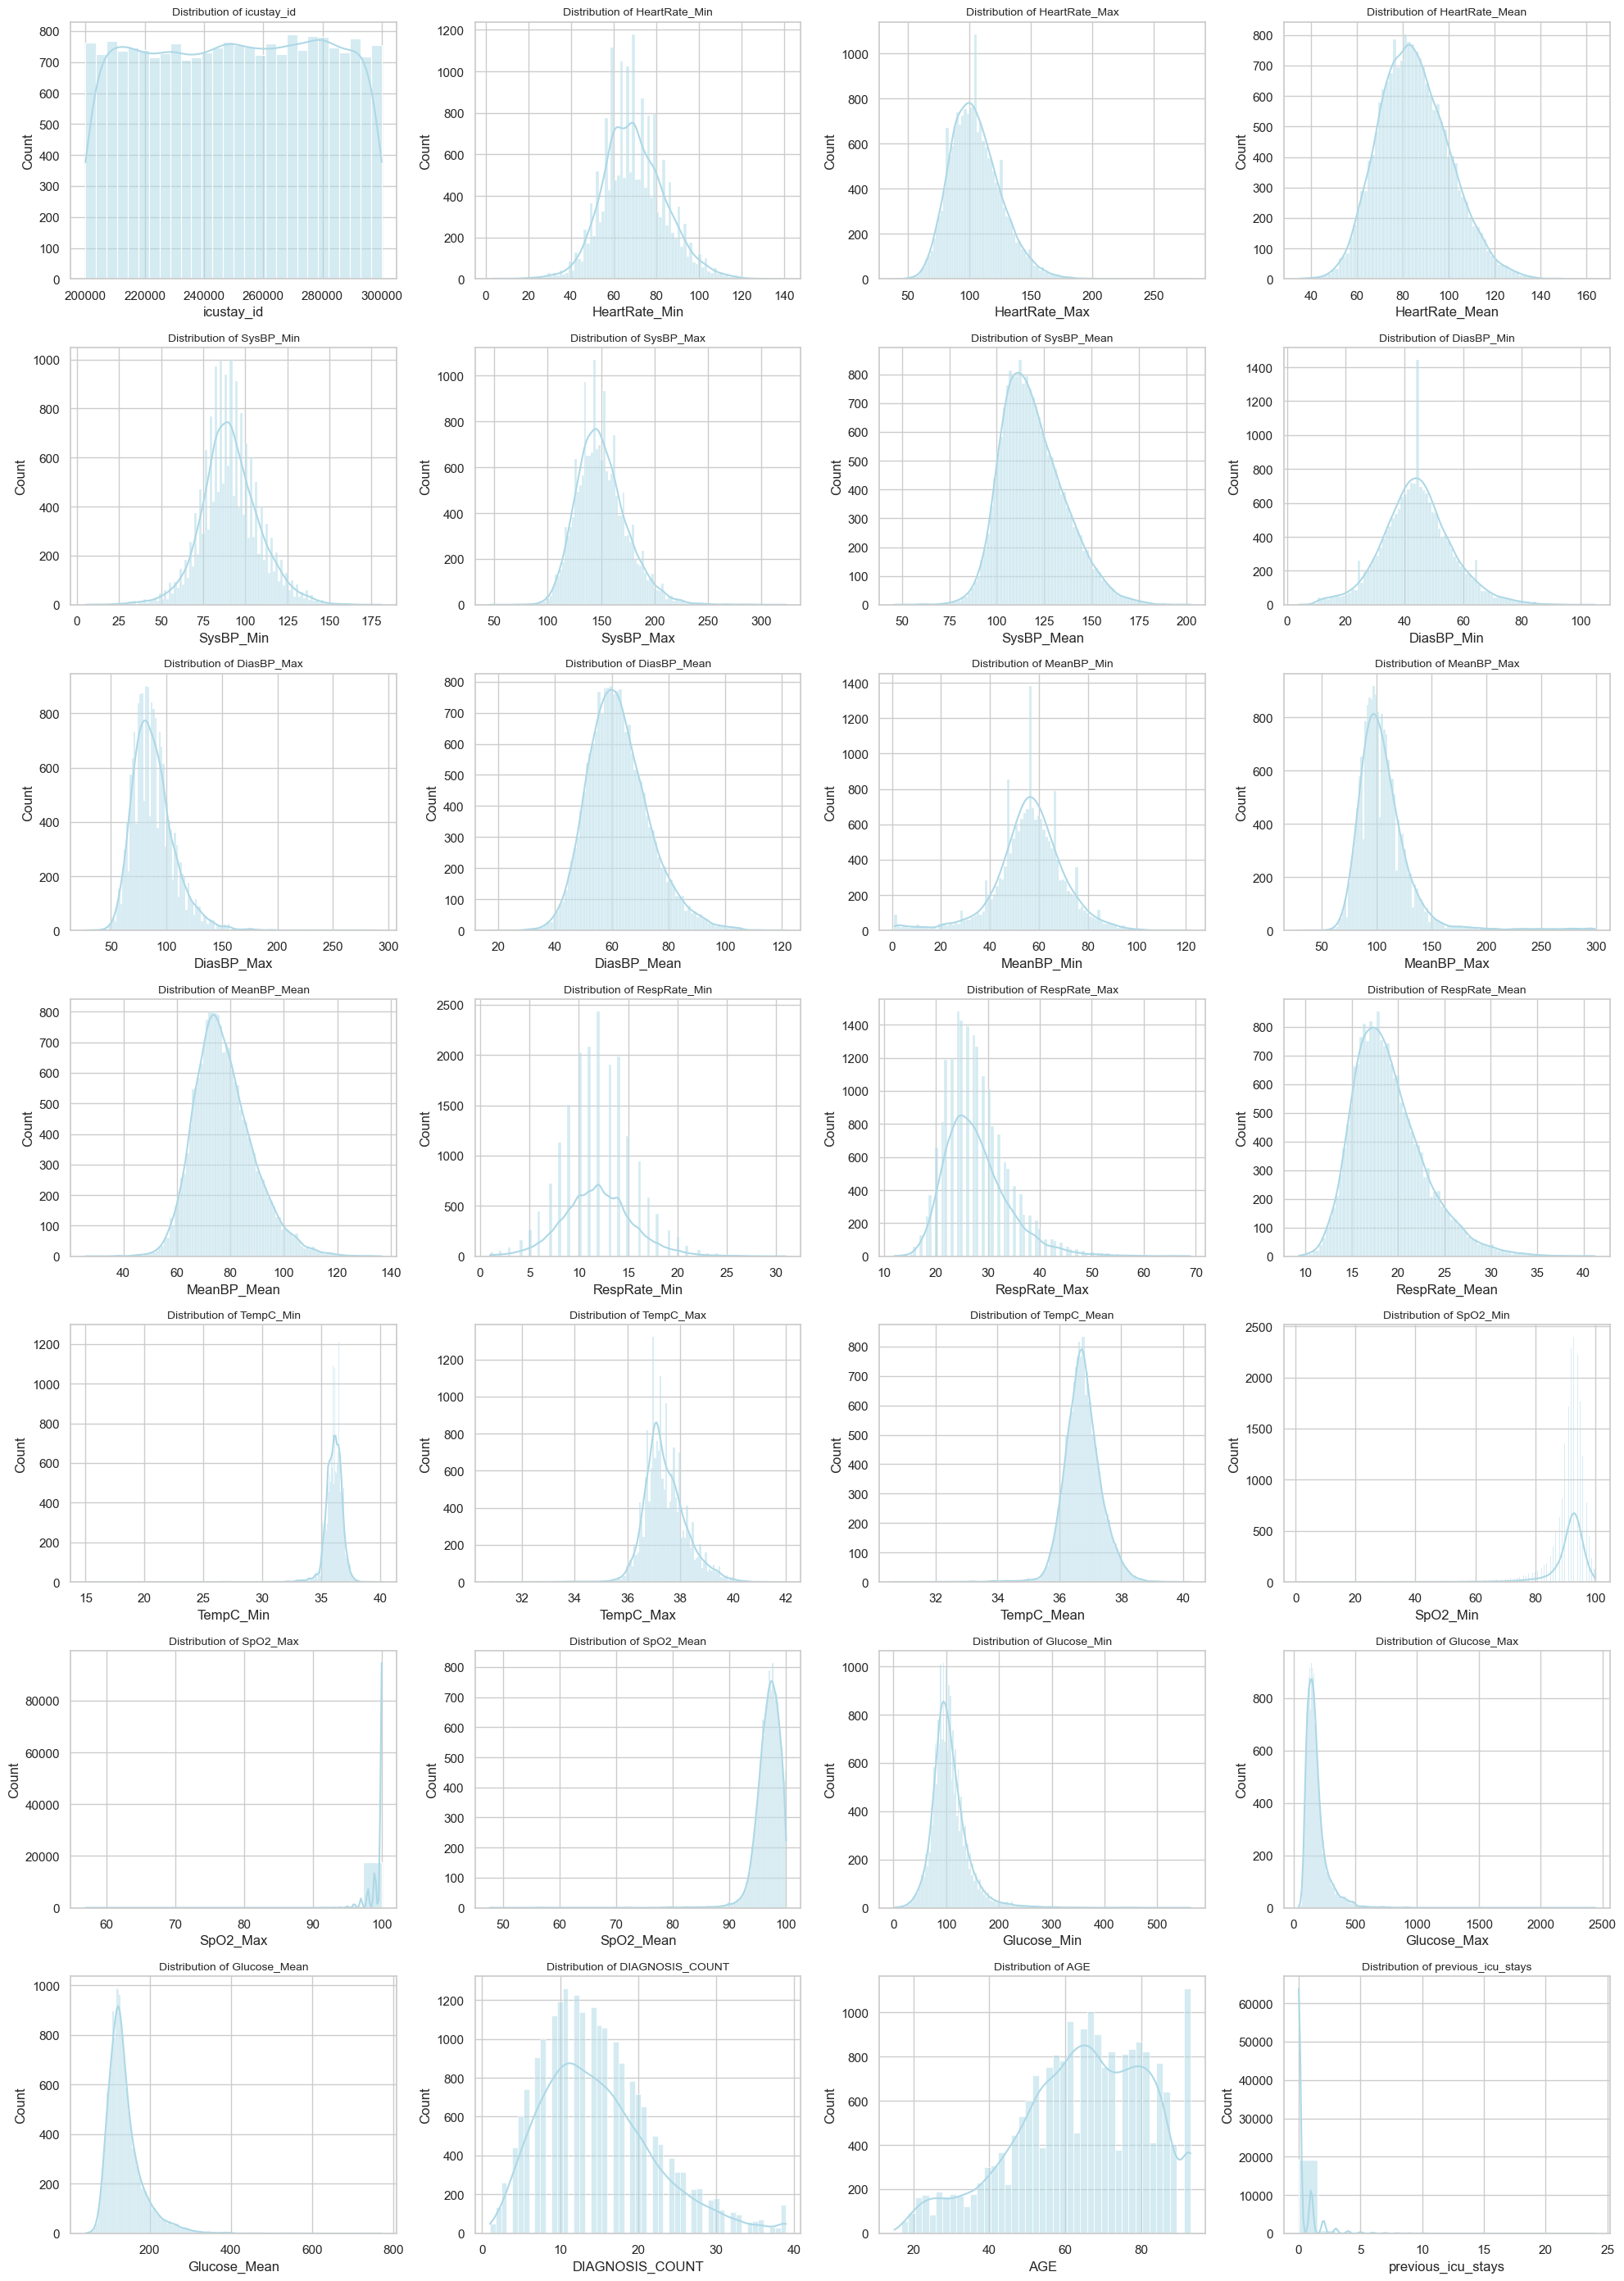

In [161]:
# List of numerical columns to plot
num_cols = [
    'icustay_id', 'HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 
    'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 
    'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min', 
    'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean', 
    'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max', 
    'Glucose_Mean', 'DIAGNOSIS_COUNT', 'AGE', 'previous_icu_stays'
]

# Number of columns per row for the plots
plots_per_row = 4

# Calculate the number of rows needed for the plots
num_rows = np.ceil(len(num_cols) / plots_per_row).astype(int)

# Setting up the figure size dynamically based on the number of plots
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(plots_per_row * 5, num_rows * 4))

# Flattening the axes array for easy indexing
axes = axes.flatten()

# Loop over each column and plot the histogram
for i, col in enumerate(num_cols):
    # Plotting the histogram with a kernel density estimate (KDE)
    sns.histplot(df_train[col], kde=True, ax=axes[i], color='lightblue', alpha=0.5)
    
    # Setting titles and adjusting aesthetics
    axes[i].set_title(f'Distribution of {col}', fontsize=10)
    axes[i].grid(True)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()


In [162]:
# After inspection of the KDE histograms, identified outliers are removed from 'TempC_Min' and 'HeartRate_Max' columns
print("Number of 'TempC_Min' outliers below 25°C in training set:", sum(df_train['TempC_Min'] < 25))
print("Number of 'TempC_Min' outliers below 25°C in test set:", sum(df_test['TempC_Min'] < 25))
df_train.loc[df_train['TempC_Min'] < 25, 'TempC_Min'] = np.nan
df_test.loc[df_test['TempC_Min'] < 25, 'TempC_Min'] = np.nan

print("Number of 'HeartRate_Max' outliers above 250 bpm in training set:", sum(df_train['HeartRate_Max'] > 250))
print("Number of 'HeartRate_Max' outliers above 250 bpm in test set:", sum(df_test['HeartRate_Max'] > 250))
df_train.loc[df_train['HeartRate_Max'] > 250, 'HeartRate_Max'] = np.nan
df_test.loc[df_test['HeartRate_Max'] > 250, 'HeartRate_Max'] = np.nan


Number of 'TempC_Min' outliers below 25°C in training set: 2
Number of 'TempC_Min' outliers below 25°C in test set: 1
Number of 'HeartRate_Max' outliers above 250 bpm in training set: 1
Number of 'HeartRate_Max' outliers above 250 bpm in test set: 0


In [163]:
# Transformation based on medical rationale: individuals with SpO2 levels below 95% are marked as 'low'
df_train['SpO2_low'] = np.where(df_train['SpO2_Mean'] < 95, 1, 0)
df_test['SpO2_low'] = np.where(df_test['SpO2_Mean'] < 95, 1, 0)

# Print counts of individuals with low SpO2 levels in training and test sets
print("Number of individuals with low SpO2 levels in training set:", df_train['SpO2_low'].sum())
print("Number of individuals with low SpO2 levels in test set:", df_test['SpO2_low'].sum())


Number of individuals with low SpO2 levels in training set: 2680
Number of individuals with low SpO2 levels in test set: 640


In [164]:
# After analyzing KDE histogram for 'previous_icu_stays', the positive values are deemed outliers, so the variable is transformed into a binary one
df_train['prev_icu_dummy'] = np.where(df_train['previous_icu_stays'] == 0, 0, 1)
df_test['prev_icu_dummy'] = np.where(df_test['previous_icu_stays'] == 0, 0, 1)

# Drop the 'previous_icu_stays' column
df_train.drop('previous_icu_stays', axis=1, inplace=True)
df_test.drop('previous_icu_stays', axis=1, inplace=True)

# Display value counts of the transformed variable
print("\nValue counts of 'prev_icu_dummy' in training set:")
display(df_train['prev_icu_dummy'].value_counts())
print("Value counts of 'prev_icu_dummy' in test set:")
display(df_test['prev_icu_dummy'].value_counts())



Value counts of 'prev_icu_dummy' in training set:


prev_icu_dummy
0    16317
1     4568
Name: count, dtype: int64

Value counts of 'prev_icu_dummy' in test set:


prev_icu_dummy
0    4847
1     374
Name: count, dtype: int64

### 2.7 Categorical Columns Analysis

In [165]:
# Retrieve numerical and categorical columns
num_cols, cat_cols = get_num_cat_cols()

# Print numerical column names
print("Numerical columns:")
print(num_cols)

# Print categorical column names
print("\nCategorical columns:")
print(cat_cols)


Numerical columns:
['icustay_id', 'HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max', 'Glucose_Mean', 'DIAGNOSIS_COUNT', 'AGE', 'ADMIT_HOUR', 'SpO2_low', 'prev_icu_dummy']

Categorical columns:
['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'FIRST_CAREUNIT', 'code1', 'code2', 'code3', 'code4', 'code5', 'code6', 'code7', 'code8', 'code9', 'code10', 'code11', 'code12', 'code13', 'code14', 'code15', 'code16', 'code17', 'code18', 'code19', 'code20', 'code21', 'code22', 'code23', 'code24', 'code25', 'code26', 'code27', 'code28', 'code29', 'code30', 'code31', 'code32', 'code33', 'code34', 'code35', 'code36', 'code37', 'code38', 'code39']


In [166]:
# Retrieve numerical and categorical columns excluding the columns in cols_out_of_list
num_cols, cat_cols = get_num_cat_cols()

# Exclude columns not in 'cols_out_of_list' from the categorical columns
cat_cols = [c for c in cat_cols if c not in cols_out_of_list]

# Print numerical column names
print("Numerical columns:")
print(num_cols)

# Print categorical column names after exclusion
print("\nCategorical columns after exclusion:")
print(cat_cols)


Numerical columns:
['icustay_id', 'HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max', 'Glucose_Mean', 'DIAGNOSIS_COUNT', 'AGE', 'ADMIT_HOUR', 'SpO2_low', 'prev_icu_dummy']

Categorical columns after exclusion:
['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'FIRST_CAREUNIT']


In [167]:
# Display the number of unique values for each categorical column
for col in cat_cols:
    unique_values = df_train[col].nunique()
    print(f"Number of unique values in {col}: {unique_values}")

Number of unique values in GENDER: 2
Number of unique values in ADMISSION_TYPE: 3
Number of unique values in INSURANCE: 5
Number of unique values in RELIGION: 17
Number of unique values in MARITAL_STATUS: 7
Number of unique values in ETHNICITY: 41
Number of unique values in FIRST_CAREUNIT: 5


In [168]:
#Want to get a sense of the remaining caterogical columns
#Iterate over each categorical column in the list
for col in cat_cols:
    # Print column name
    print(f"Column: {col}")
    # Print value counts of each category in the column
    for index, value in df_train[col].value_counts().items():
        print(f"  {index}: {value}")
    print('\n')

# Print the total number of categorical columns
print("Total number of categorical columns:", len(cat_cols))


Column: GENDER
  M: 11759
  F: 9126


Column: ADMISSION_TYPE
  EMERGENCY: 17817
  ELECTIVE: 2848
  URGENT: 220


Column: INSURANCE
  Medicare: 11718
  Private: 6245
  Medicaid: 2117
  Government: 611
  Self Pay: 194


Column: RELIGION
  CATHOLIC: 7655
  NOT SPECIFIED: 5398
  PROTESTANT QUAKER: 2753
  JEWISH: 1840
  UNOBTAINABLE: 1515
  OTHER: 702
  EPISCOPALIAN: 288
  GREEK ORTHODOX: 178
  CHRISTIAN SCIENTIST: 164
  BUDDHIST: 109
  MUSLIM: 74
  UNITARIAN-UNIVERSALIST: 54
  JEHOVAH'S WITNESS: 45
  ROMANIAN EAST. ORTH: 41
  HINDU: 38
  7TH DAY ADVENTIST: 30
  HEBREW: 1


Column: MARITAL_STATUS
  MARRIED: 9664
  SINGLE: 5910
  WIDOWED: 2819
  DIVORCED: 1413
  SEPARATED: 240
  UNKNOWN (DEFAULT): 103
  LIFE PARTNER: 14


Column: ETHNICITY
  WHITE: 15112
  BLACK/AFRICAN AMERICAN: 1977
  UNABLE TO OBTAIN: 577
  UNKNOWN/NOT SPECIFIED: 568
  HISPANIC OR LATINO: 562
  OTHER: 489
  ASIAN: 265
  PATIENT DECLINED TO ANSWER: 175
  HISPANIC/LATINO - PUERTO RICAN: 155
  ASIAN - CHINESE: 146
  BLACK/CA

### 2.8 Reglion, Ethnicity & Martial Type Pre-Processing 

In [169]:
df_train['MARITAL_STATUS'].value_counts()

MARITAL_STATUS
MARRIED              9664
SINGLE               5910
WIDOWED              2819
DIVORCED             1413
SEPARATED             240
UNKNOWN (DEFAULT)     103
LIFE PARTNER           14
Name: count, dtype: int64

In [170]:
marital_result = df_train.groupby('MARITAL_STATUS')['LOS'].mean()
marital_result

MARITAL_STATUS
DIVORCED             3.732979
LIFE PARTNER         4.371564
MARRIED              3.754372
SEPARATED            3.843752
SINGLE               3.652800
UNKNOWN (DEFAULT)    4.317781
WIDOWED              3.502518
Name: LOS, dtype: float64

In [171]:
# Handling missing values and consolidating categories in 'MARITAL_STATUS'

# Replace NaN values and 'UNKNOWN (DEFAULT)' with 'UNKNOWN' in 'MARITAL_STATUS' for both train and test dataframes
for df in [df_train, df_test]:
    # Fill NaN values with 'UNKNOWN'
    df['MARITAL_STATUS'].fillna('UNKNOWN', inplace=True)

    # Replace 'UNKNOWN (DEFAULT)' with 'UNKNOWN'
    df['MARITAL_STATUS'].replace('UNKNOWN (DEFAULT)', 'UNKNOWN', inplace=True)

    # Display the updated value counts for 'MARITAL_STATUS'
    print(f"Value counts in {df.name if hasattr(df, 'name') else 'DataFrame'} for 'MARITAL_STATUS':")
    display(df['MARITAL_STATUS'].value_counts())

Value counts in DataFrame for 'MARITAL_STATUS':


MARITAL_STATUS
MARRIED         9664
SINGLE          5910
WIDOWED         2819
DIVORCED        1413
UNKNOWN          825
SEPARATED        240
LIFE PARTNER      14
Name: count, dtype: int64

Value counts in DataFrame for 'MARITAL_STATUS':


MARITAL_STATUS
MARRIED         2461
SINGLE          1438
WIDOWED          709
DIVORCED         353
UNKNOWN          208
SEPARATED         51
LIFE PARTNER       1
Name: count, dtype: int64

In [172]:
df_train['ETHNICITY'].value_counts()

ETHNICITY
WHITE                                                       15112
BLACK/AFRICAN AMERICAN                                       1977
UNABLE TO OBTAIN                                              577
UNKNOWN/NOT SPECIFIED                                         568
HISPANIC OR LATINO                                            562
OTHER                                                         489
ASIAN                                                         265
PATIENT DECLINED TO ANSWER                                    175
HISPANIC/LATINO - PUERTO RICAN                                155
ASIAN - CHINESE                                               146
BLACK/CAPE VERDEAN                                            126
WHITE - RUSSIAN                                               117
BLACK/HAITIAN                                                  72
HISPANIC/LATINO - DOMINICAN                                    59
ASIAN - ASIAN INDIAN                                           58


In [173]:
def simplify_ethnicity(df):
    """
    Simplify the 'ETHNICITY' column
    """
    # Extract the first word from each entry in 'ETHNICITY'
    df['ETHNICITY'] = df['ETHNICITY'].str.extract(r"^(\w+)")

    # Create a dictionary mapping specific values to new simplified categories
    ethnicity_mapping = {
        'UNABLE': 'UNKNOWN', 'PATIENT': 'UNKNOWN', 'MULTI': 'UNKNOWN', 
        'MIDDLE': 'MIDDLE EASTERN', 'NATIVE': 'OTHER', 'AMERICAN': 'AMERICAN INDIAN', 
        'SOUTH': 'HISPANIC', 'CARIBBEAN': 'OTHER', 'PORTUGUESE': 'WHITE'
    }

    # Apply the mapping to the 'ETHNICITY' column
    df['ETHNICITY'] = df['ETHNICITY'].replace(ethnicity_mapping)

# Apply the simplification to both training and test datasets
simplify_ethnicity(df_train)
simplify_ethnicity(df_test)

# Print the value counts of the simplified 'ETHNICITY' categories for the training dataset
print("Simplified Ethnicity Counts in Training Data:")
print(df_train['ETHNICITY'].value_counts())

# Print the value counts of the simplified 'ETHNICITY' categories for the test dataset
print("\nSimplified Ethnicity Counts in Test Data:")
print(df_test['ETHNICITY'].value_counts())


Simplified Ethnicity Counts in Training Data:
ETHNICITY
WHITE              15370
BLACK               2201
UNKNOWN             1370
HISPANIC             859
ASIAN                545
OTHER                501
MIDDLE EASTERN        24
AMERICAN INDIAN       15
Name: count, dtype: int64

Simplified Ethnicity Counts in Test Data:
ETHNICITY
WHITE              3866
BLACK               532
UNKNOWN             364
HISPANIC            203
ASIAN               144
OTHER               103
MIDDLE EASTERN        8
AMERICAN INDIAN       1
Name: count, dtype: int64


I apply the different encoders to the different variables we want to encode to remove categorical values.

In [174]:
df_train['INSURANCE'].value_counts()

INSURANCE
Medicare      11718
Private        6245
Medicaid       2117
Government      611
Self Pay        194
Name: count, dtype: int64

In [175]:
def consolidate_insurance(df):
    """
    Consolidate 'Medicare' and 'Medicaid' into 'Government', and 'Self Pay' into 'Private' in the 'INSURANCE' column.
    """
    # Replace 'Medicare' and 'Medicaid' with 'Government'
    df['INSURANCE'].replace(['Medicare', 'Medicaid'], 'Government', inplace=True)

    # Replace 'Self Pay' with 'Private'
    df['INSURANCE'].replace('Self Pay', 'Private', inplace=True)

# Apply the function to both df_train and df_test
consolidate_insurance(df_train)
consolidate_insurance(df_test)

# Print the updated value counts for the 'INSURANCE' column
print("Updated Insurance Counts in Training Data:")
print(df_train['INSURANCE'].value_counts())

print("\nUpdated Insurance Counts in Test Data:")
print(df_test['INSURANCE'].value_counts())

Updated Insurance Counts in Training Data:
INSURANCE
Government    14446
Private        6439
Name: count, dtype: int64

Updated Insurance Counts in Test Data:
INSURANCE
Government    3639
Private       1582
Name: count, dtype: int64


In [176]:
df_train['RELIGION'].value_counts()

RELIGION
CATHOLIC                  7655
NOT SPECIFIED             5398
PROTESTANT QUAKER         2753
JEWISH                    1840
UNOBTAINABLE              1515
OTHER                      702
EPISCOPALIAN               288
GREEK ORTHODOX             178
CHRISTIAN SCIENTIST        164
BUDDHIST                   109
MUSLIM                      74
UNITARIAN-UNIVERSALIST      54
JEHOVAH'S WITNESS           45
ROMANIAN EAST. ORTH         41
HINDU                       38
7TH DAY ADVENTIST           30
HEBREW                       1
Name: count, dtype: int64

In [177]:
def update_religion_column(df):
    """
    Update the 'RELIGION' column in the given dataframe.
    - Turn 'HEBREW' into 'OTHER'
    - Merge 'OTHER' into 'UNSPECIFIED'
    """
    # Replace 'HEBREW' with 'OTHER'
    df['RELIGION'].replace('HEBREW', 'OTHER', inplace=True)

    # Merge 'OTHER' into 'UNSPECIFIED'
    df['RELIGION'].replace('OTHER', 'UNSPECIFIED', inplace=True)

# Apply the function to both df_train and df_test
update_religion_column(df_train)
update_religion_column(df_test)

# Print the updated value counts for the 'RELIGION' column
print("Updated Religion Counts in Training Data:")
print(df_train['RELIGION'].value_counts())

print("\nUpdated Religion Counts in Test Data:")
print(df_test['RELIGION'].value_counts())

Updated Religion Counts in Training Data:
RELIGION
CATHOLIC                  7655
NOT SPECIFIED             5398
PROTESTANT QUAKER         2753
JEWISH                    1840
UNOBTAINABLE              1515
UNSPECIFIED                703
EPISCOPALIAN               288
GREEK ORTHODOX             178
CHRISTIAN SCIENTIST        164
BUDDHIST                   109
MUSLIM                      74
UNITARIAN-UNIVERSALIST      54
JEHOVAH'S WITNESS           45
ROMANIAN EAST. ORTH         41
HINDU                       38
7TH DAY ADVENTIST           30
Name: count, dtype: int64

Updated Religion Counts in Test Data:
RELIGION
CATHOLIC                  1898
NOT SPECIFIED             1361
PROTESTANT QUAKER          697
JEWISH                     446
UNOBTAINABLE               395
UNSPECIFIED                182
EPISCOPALIAN                62
GREEK ORTHODOX              50
CHRISTIAN SCIENTIST         29
BUDDHIST                    25
MUSLIM                      17
JEHOVAH'S WITNESS           14
ROMANIA

In [178]:
display(df_train)
display(df_test)

,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,...,code34,code35,code36,code37,code38,code39,AGE,ADMIT_HOUR,SpO2_low,prev_icu_dummy
0,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,42.0,90.0,61.173913,...,None,None,None,None,None,None,70.0,15,0,0
1,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,49.0,74.0,64.733333,...,None,None,None,None,None,None,42.0,18,0,0
2,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,45.0,67.0,56.821429,...,None,None,None,None,None,None,68.0,23,0,0
3,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,30.0,89.0,41.864865,...,None,None,None,None,None,None,75.0,22,0,0
4,225281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,79.0,7,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20880,244530,65.0,92.0,78.500000,60.0,160.0,110.976190,34.0,94.0,56.595238,...,None,None,None,None,None,None,88.0,8,0,1
20881,216116,74.0,112.0,89.156250,100.0,150.0,123.272727,58.0,83.0,67.818182,...,None,None,None,None,None,None,66.0,4,0,1
20882,274507,58.0,97.0,76.933333,94.0,131.0,112.037037,55.0,83.0,67.370370,...,None,None,None,None,None,None,63.0,15,0,0
20883,225930,59.0,102.0,81.844444,96.0,150.0,123.837209,47.0,85.0,60.232558,...,None,None,None,None,None,None,93.0,14,0,0


,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,...,code34,code35,code36,code37,code38,code39,AGE,ADMIT_HOUR,SpO2_low,prev_icu_dummy
0,208169,58.0,90.0,85.244898,77.0,153.0,98.490909,40.0,77.0,52.018182,...,None,None,None,None,None,None,82.0,1,0,0
1,251754,91.0,145.0,115.055556,73.0,143.0,101.210526,42.0,86.0,65.578947,...,None,None,None,None,None,None,48.0,21,0,0
2,242171,106.0,132.0,117.750000,93.0,137.0,116.222222,51.0,76.0,66.703704,...,None,None,None,None,None,None,42.0,16,0,1
3,263035,72.0,105.0,83.627119,72.0,168.0,126.981818,39.0,99.0,62.854545,...,None,None,None,None,None,None,84.0,7,0,0
4,279388,85.0,124.0,98.600000,86.0,144.0,110.666667,52.0,133.0,72.833333,...,None,None,None,None,None,None,53.0,23,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5216,278087,63.0,131.0,97.130435,108.0,140.0,122.631579,49.0,79.0,62.631579,...,53081,6983,71590,6961,27800,2809,59.0,20,1,0
5217,266914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,76.0,8,0,0
5218,213413,74.0,91.0,81.488372,117.0,171.0,143.395349,48.0,97.0,64.209302,...,None,None,None,None,None,None,81.0,5,1,1
5219,286384,70.0,89.0,80.276596,68.0,137.0,110.680851,42.0,74.0,55.702128,...,None,None,None,None,None,None,79.0,3,0,0


In [179]:
# Define columns for One-Hot Encoding
cols_OH = [
    'FIRST_CAREUNIT',
    'MARITAL_STATUS',
    'ETHNICITY',
    'INSURANCE',
    'ADMISSION_TYPE',
    'GENDER',
    'AGE'
]

# Define columns for Binary Encoding
cols_binary = [
    'RELIGION'
]

"""
Retrieve the most frequent category for each variable
"""
most_frequent_categories = [df_train[col].mode()[0] for col in cat_cols]

# Print the most frequent categories for each variable
print("Most frequent categories for each variable:", most_frequent_categories)


Most frequent categories for each variable: ['M', 'EMERGENCY', 'Government', 'CATHOLIC', 'MARRIED', 'WHITE', 'MICU']


One-hot Encoding

In [180]:
# Initialize One-Hot Encoder without dropping any category to manage multicollinearity later
oh_encoder = OneHotEncoder(handle_unknown='ignore', drop=None, sparse_output=False)

# Create copies of the categorical columns for transformation
df_train_oh = df_train[cols_OH].copy()
df_test_oh = df_test[cols_OH].copy()

# Fit the encoder to the training data and transform both datasets
oh_encoder_tr = oh_encoder.fit(df_train_oh)
df_train_encoded = oh_encoder_tr.transform(df_train_oh)
df_test_encoded = oh_encoder_tr.transform(df_test_oh)

# Retrieve the new column names post-encoding
columns = oh_encoder_tr.get_feature_names_out(input_features=cols_OH)

# Create DataFrames with encoded data, maintaining original index
df_train_oh_final = pd.DataFrame(df_train_encoded, columns=columns, index=df_train.index)
df_test_oh_final = pd.DataFrame(df_test_encoded, columns=columns, index=df_test.index)

# Concatenate the encoded columns with the original dataframes, dropping the original categorical columns
df_train = pd.concat([df_train.drop(columns=cols_OH, axis=1), df_train_oh_final], axis=1)
df_test = pd.concat([df_test.drop(columns=cols_OH, axis=1), df_test_oh_final], axis=1)

# Display the final transformed training dataset
print("Transformed Training Dataset with One-Hot Encoded Features:")
display(df_train)

# Display the final transformed testing dataset
print("Transformed Testing Dataset with One-Hot Encoded Features:")
display(df_test)


Transformed Training Dataset with One-Hot Encoded Features:


,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,...,AGE_81.0,AGE_82.0,AGE_83.0,AGE_84.0,AGE_85.0,AGE_86.0,AGE_87.0,AGE_88.0,AGE_89.0,AGE_93.0
0,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,42.0,90.0,61.173913,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,49.0,74.0,64.733333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,45.0,67.0,56.821429,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,30.0,89.0,41.864865,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,225281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20880,244530,65.0,92.0,78.500000,60.0,160.0,110.976190,34.0,94.0,56.595238,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
20881,216116,74.0,112.0,89.156250,100.0,150.0,123.272727,58.0,83.0,67.818182,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20882,274507,58.0,97.0,76.933333,94.0,131.0,112.037037,55.0,83.0,67.370370,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20883,225930,59.0,102.0,81.844444,96.0,150.0,123.837209,47.0,85.0,60.232558,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Transformed Testing Dataset with One-Hot Encoded Features:


,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,...,AGE_81.0,AGE_82.0,AGE_83.0,AGE_84.0,AGE_85.0,AGE_86.0,AGE_87.0,AGE_88.0,AGE_89.0,AGE_93.0
0,208169,58.0,90.0,85.244898,77.0,153.0,98.490909,40.0,77.0,52.018182,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,251754,91.0,145.0,115.055556,73.0,143.0,101.210526,42.0,86.0,65.578947,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,242171,106.0,132.0,117.750000,93.0,137.0,116.222222,51.0,76.0,66.703704,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,263035,72.0,105.0,83.627119,72.0,168.0,126.981818,39.0,99.0,62.854545,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,279388,85.0,124.0,98.600000,86.0,144.0,110.666667,52.0,133.0,72.833333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5216,278087,63.0,131.0,97.130435,108.0,140.0,122.631579,49.0,79.0,62.631579,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5217,266914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5218,213413,74.0,91.0,81.488372,117.0,171.0,143.395349,48.0,97.0,64.209302,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5219,286384,70.0,89.0,80.276596,68.0,137.0,110.680851,42.0,74.0,55.702128,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2.9 Binary Encoding

In [181]:
# Initialize binary encoder for the Religion column
binary_encoder = ce.BinaryEncoder(cols=cols_binary, return_df=True)

# Copy the Religion column for both training and testing sets
df_train_binary = df_train[cols_binary].copy()
df_test_binary = df_test[cols_binary].copy()

# Fit the encoder to the training data and transform both datasets
binary_tr = binary_encoder.fit(df_train[cols_binary])
df_train_binary_encd = binary_tr.transform(df_train_binary)
df_test_binary_encd = binary_tr.transform(df_test_binary)

# Display the binary-encoded training data for inspection
display(df_train_binary_encd)

# Concatenate the encoded columns with the original dataframes,
# dropping the original Religion columns
df_train = pd.concat([df_train.drop(columns=cols_binary, axis=1), df_train_binary_encd], axis=1)
df_test = pd.concat([df_test.drop(columns=cols_binary, axis=1), df_test_binary_encd], axis=1)

# Display the updated datasets for verification
display(df_train)
display(df_test)


,RELIGION_0,RELIGION_1,RELIGION_2,RELIGION_3,RELIGION_4
0,0,0,0,0,1
1,0,0,0,1,0
2,0,0,0,0,1
3,0,0,0,1,1
4,0,0,1,0,0
...,...,...,...,...,...
20880,0,0,1,0,1
20881,0,0,0,1,1
20882,0,0,0,0,1
20883,0,0,0,0,1


,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,...,AGE_86.0,AGE_87.0,AGE_88.0,AGE_89.0,AGE_93.0,RELIGION_0,RELIGION_1,RELIGION_2,RELIGION_3,RELIGION_4
0,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,42.0,90.0,61.173913,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1
1,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,49.0,74.0,64.733333,...,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0
2,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,45.0,67.0,56.821429,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1
3,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,30.0,89.0,41.864865,...,0.0,0.0,0.0,0.0,0.0,0,0,0,1,1
4,225281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20880,244530,65.0,92.0,78.500000,60.0,160.0,110.976190,34.0,94.0,56.595238,...,0.0,0.0,1.0,0.0,0.0,0,0,1,0,1
20881,216116,74.0,112.0,89.156250,100.0,150.0,123.272727,58.0,83.0,67.818182,...,0.0,0.0,0.0,0.0,0.0,0,0,0,1,1
20882,274507,58.0,97.0,76.933333,94.0,131.0,112.037037,55.0,83.0,67.370370,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1
20883,225930,59.0,102.0,81.844444,96.0,150.0,123.837209,47.0,85.0,60.232558,...,0.0,0.0,0.0,0.0,1.0,0,0,0,0,1


,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,...,AGE_86.0,AGE_87.0,AGE_88.0,AGE_89.0,AGE_93.0,RELIGION_0,RELIGION_1,RELIGION_2,RELIGION_3,RELIGION_4
0,208169,58.0,90.0,85.244898,77.0,153.0,98.490909,40.0,77.0,52.018182,...,0.0,0.0,0.0,0.0,0.0,0,0,1,0,1
1,251754,91.0,145.0,115.055556,73.0,143.0,101.210526,42.0,86.0,65.578947,...,0.0,0.0,0.0,0.0,0.0,0,0,0,1,1
2,242171,106.0,132.0,117.750000,93.0,137.0,116.222222,51.0,76.0,66.703704,...,0.0,0.0,0.0,0.0,0.0,0,0,1,0,1
3,263035,72.0,105.0,83.627119,72.0,168.0,126.981818,39.0,99.0,62.854545,...,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0
4,279388,85.0,124.0,98.600000,86.0,144.0,110.666667,52.0,133.0,72.833333,...,0.0,0.0,0.0,0.0,0.0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5216,278087,63.0,131.0,97.130435,108.0,140.0,122.631579,49.0,79.0,62.631579,...,0.0,0.0,0.0,0.0,0.0,0,0,1,1,0
5217,266914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1
5218,213413,74.0,91.0,81.488372,117.0,171.0,143.395349,48.0,97.0,64.209302,...,0.0,0.0,0.0,0.0,0.0,0,1,0,1,0
5219,286384,70.0,89.0,80.276596,68.0,137.0,110.680851,42.0,74.0,55.702128,...,0.0,0.0,0.0,0.0,0.0,0,0,1,0,1


In [182]:
print("Most Frequent Categories in Each Variable:")
print(most_frequent_categories)

# Define the categories to be dropped to avoid multicollinearity
cats_drop = [
    'GENDER_M',  # Most frequent category in GENDER
    'ADMISSION_TYPE_EMERGENCY',  # Most frequent category in ADMISSION_TYPE
    'INSURANCE_Government', # Example of a dropped line, not to be executed
    # 'RELIGION_CATHOLIC', - Not dropped, as 'RELIGION' underwent binary encoding
    'MARITAL_STATUS_MARRIED',  # Most frequent category in MARITAL_STATUS
    'ETHNICITY_WHITE',  # Most frequent category in ETHNICITY
    'FIRST_CAREUNIT_MICU',  # Most frequent category in FIRST_CAREUNIT
]
# Drop the selected categories from the training and testing datasets
df_train.drop(columns = cats_drop, axis = 1, inplace = True)
df_test.drop(columns = cats_drop, axis = 1, inplace = True)

print("Columns dropped to address multicollinearity. Dataframes updated.")

Most Frequent Categories in Each Variable:
['M', 'EMERGENCY', 'Government', 'CATHOLIC', 'MARRIED', 'WHITE', 'MICU']
Columns dropped to address multicollinearity. Dataframes updated.


### 2.11 Grouping Medical Columns & Dropping Unused Columns

In [183]:
def grouped_vitals(col_name: str, df: pd.DataFrame):
    # Define new column names for mean, minimum, and maximum values
    col_mean = col_name + '_Mean'
    col_min = col_name + '_Min'
    col_max = col_name + '_Max'
    
    # Create a new column in the dataframe that averages the mean value of the vital
    # and the average of the minimum and maximum values.
    # This provides a more comprehensive representation of the vital statistic.
    df[col_name] = 0.5 * df[col_mean] + 0.5 * df[[col_min, col_max]].mean(axis=1)

# List of vital signs to be grouped using the above function
grouping_cols = [
    'HeartRate',
    'SysBP',      # Systolic Blood Pressure
    'DiasBP',     # Diastolic Blood Pressure
    'MeanBP',     # Mean Blood Pressure
    'RespRate',   # Respiratory Rate
    'TempC',      # Temperature in Celsius
    'Glucose'     # Glucose level
]

# Apply the grouping function to each of the vital signs in both training and testing datasets
for c in grouping_cols:
    grouped_vitals(c, df_train)
    grouped_vitals(c, df_test)

# Calculate a composite 'BloodPressure' score.
# This score is derived by combining the SysBP, DiasBP, and MeanBP measurements,
# with weights of 10%, 40%, and 50% respectively.
# This new metric potentially offers a more nuanced understanding of the patient's blood pressure status.
df_train['BloodPressure'] = 0.1 * df_train['SysBP'] + 0.4 * df_train['DiasBP'] + 0.5 * df_train['MeanBP']
df_test['BloodPressure'] = 0.1 * df_test['SysBP'] + 0.4 * df_test['DiasBP'] + 0.5 * df_test['MeanBP']


In [184]:
# Dropping columns to reduce multicollinearity


# Columns to be dropped from the datasets
cols_drop_2 = [
    'HeartRate_Mean', 'HeartRate_Min', 'HeartRate_Max',
    'SysBP_Mean', 'SysBP_Min', 'SysBP_Max',
    'DiasBP_Mean', 'DiasBP_Min', 'DiasBP_Max',
    'MeanBP_Mean', 'MeanBP_Min', 'MeanBP_Max',
    'RespRate_Mean', 'RespRate_Min', 'RespRate_Max',
    'TempC_Mean', 'TempC_Min', 'TempC_Max',
    'Glucose_Mean', 'Glucose_Min', 'Glucose_Max',
    'SysBP', 'DiasBP', 'MeanBP','SpO2_Min', 'SpO2_Max', 'SpO2_Mean','icustay_id'
]

# Dropping the specified columns from the training and testing datasets
df_train.drop(cols_drop_2, axis=1, inplace=True)
df_test.drop(cols_drop_2, axis=1, inplace=True)

# Print statement to confirm the completion of the operation
print("Columns related to 'Min, Max, Mean' of vital indicators and Blood Pressure measurements have been dropped to reduce multicollinearity.")


Columns related to 'Min, Max, Mean' of vital indicators and Blood Pressure measurements have been dropped to reduce multicollinearity.


In [185]:
# Extracting numerical and categorical columns from the dataset
num_cols, cat_cols = get_num_cat_cols()

# Displaying the list of numerical columns, 
print("Numerical Columns:", num_cols)

# Displaying the list of categorical columns, now encoded
print("Categorical Columns:", cat_cols)


Numerical Columns: ['DIAGNOSIS_COUNT', 'ADMIT_HOUR', 'SpO2_low', 'prev_icu_dummy', 'FIRST_CAREUNIT_CCU', 'FIRST_CAREUNIT_CSRU', 'FIRST_CAREUNIT_SICU', 'FIRST_CAREUNIT_TSICU', 'MARITAL_STATUS_DIVORCED', 'MARITAL_STATUS_LIFE PARTNER', 'MARITAL_STATUS_SEPARATED', 'MARITAL_STATUS_SINGLE', 'MARITAL_STATUS_UNKNOWN', 'MARITAL_STATUS_WIDOWED', 'ETHNICITY_AMERICAN INDIAN', 'ETHNICITY_ASIAN', 'ETHNICITY_BLACK', 'ETHNICITY_HISPANIC', 'ETHNICITY_MIDDLE EASTERN', 'ETHNICITY_OTHER', 'ETHNICITY_UNKNOWN', 'INSURANCE_Private', 'ADMISSION_TYPE_ELECTIVE', 'ADMISSION_TYPE_URGENT', 'GENDER_F', 'AGE_15.0', 'AGE_16.0', 'AGE_17.0', 'AGE_18.0', 'AGE_19.0', 'AGE_20.0', 'AGE_21.0', 'AGE_22.0', 'AGE_23.0', 'AGE_24.0', 'AGE_25.0', 'AGE_26.0', 'AGE_27.0', 'AGE_28.0', 'AGE_29.0', 'AGE_30.0', 'AGE_31.0', 'AGE_32.0', 'AGE_33.0', 'AGE_34.0', 'AGE_35.0', 'AGE_36.0', 'AGE_37.0', 'AGE_38.0', 'AGE_39.0', 'AGE_40.0', 'AGE_41.0', 'AGE_42.0', 'AGE_43.0', 'AGE_44.0', 'AGE_45.0', 'AGE_46.0', 'AGE_47.0', 'AGE_48.0', 'AGE_49.0', 

### 2.12 Standard & Robust Scalers

In [186]:
# Preparing to scale variables based on their characteristics
non_skew_cols = []  # Will use standard scaler on these columns
skew_cols = []      # Will use robust scaler on these skewed columns
dummy_cols = []     # Dummy columns (binary indicators from categorical encoding)

for col in num_cols:
    skew = abs(df_train[col].skew())  # Calculate the absolute skewness of the column
    unique_vals = sorted(df_train[col].unique())  # Get unique values in the column
    
    # Check if the column is a dummy variable (only contains 0 and 1)
    if unique_vals == [0, 1]:
        non_skew_cols.append(col)
        dummy_cols.append(col)
    # Add highly skewed columns to skew_cols list
    elif skew > 0.5:
        skew_cols.append(col)
    # Add non-skewed columns to non_skew_cols list
    else:
        non_skew_cols.append(col)

# Display the categorized columns for different scaling techniques
print("Highly Skewed Columns:", skew_cols)
print("Non-Skewed / Dummy Columns:", non_skew_cols)
print("Dummy Columns:", dummy_cols)


Highly Skewed Columns: ['DIAGNOSIS_COUNT', 'RespRate', 'Glucose', 'BloodPressure']
Non-Skewed / Dummy Columns: ['ADMIT_HOUR', 'SpO2_low', 'prev_icu_dummy', 'FIRST_CAREUNIT_CCU', 'FIRST_CAREUNIT_CSRU', 'FIRST_CAREUNIT_SICU', 'FIRST_CAREUNIT_TSICU', 'MARITAL_STATUS_DIVORCED', 'MARITAL_STATUS_LIFE PARTNER', 'MARITAL_STATUS_SEPARATED', 'MARITAL_STATUS_SINGLE', 'MARITAL_STATUS_UNKNOWN', 'MARITAL_STATUS_WIDOWED', 'ETHNICITY_AMERICAN INDIAN', 'ETHNICITY_ASIAN', 'ETHNICITY_BLACK', 'ETHNICITY_HISPANIC', 'ETHNICITY_MIDDLE EASTERN', 'ETHNICITY_OTHER', 'ETHNICITY_UNKNOWN', 'INSURANCE_Private', 'ADMISSION_TYPE_ELECTIVE', 'ADMISSION_TYPE_URGENT', 'GENDER_F', 'AGE_15.0', 'AGE_16.0', 'AGE_17.0', 'AGE_18.0', 'AGE_19.0', 'AGE_20.0', 'AGE_21.0', 'AGE_22.0', 'AGE_23.0', 'AGE_24.0', 'AGE_25.0', 'AGE_26.0', 'AGE_27.0', 'AGE_28.0', 'AGE_29.0', 'AGE_30.0', 'AGE_31.0', 'AGE_32.0', 'AGE_33.0', 'AGE_34.0', 'AGE_35.0', 'AGE_36.0', 'AGE_37.0', 'AGE_38.0', 'AGE_39.0', 'AGE_40.0', 'AGE_41.0', 'AGE_42.0', 'AGE_43.0',

Highly Skewed Columns: Include 'DIAGNOSIS_COUNT', 'RespRate', 'Glucose', and 'BloodPressure'. These columns exhibit significant skewness in their distribution, which suggests that a robust scaling technique might be more appropriate to normalize their distribution.

Low Skewness Columns: Comprise 'icustay_id', 'ADMIT_HOUR', 'HeartRate', and 'TempC'. These columns show low skewness, indicating a more uniform distribution. Standard scaling methods are typically suitable for such columns.

Dummy Columns: Partially listed here, these are columns like 'SpO2_low', 'prev_icu_dummy', and various 'FIRST_CAREUNIT_*' columns. These are binary (0 or 1) indicators, resulting from the encoding of categorical variables. 

### 2.13 Data Splitting

In [187]:
# Separating features and target variable for training data
X = df_train.drop(target, axis=1).copy()  # Features for training (all columns except the target)
y_train = df_train[target].copy()         # Target variable for training

# Copying the test dataset as it is for model evaluation
X_test = df_test.copy()

# Display the datasets to verify their structure
display(X)        # Displaying the features of the training dataset
display(y_train)  # Displaying the target variable of the training dataset
display(X_test)   # Displaying the test dataset


,DIAGNOSIS_COUNT,code1,code2,code3,code4,code5,code6,code7,code8,code9,...,RELIGION_0,RELIGION_1,RELIGION_2,RELIGION_3,RELIGION_4,HeartRate,RespRate,TempC,Glucose,BloodPressure
0,17,5789,51881,41071,42831,42732,2851,53550,79092,4280,...,0,0,0,0,1,119.021739,22.423913,36.054012,165.638889,73.550000
1,3,53013,9351,E915,None,None,None,None,None,None,...,0,0,0,1,0,82.808824,16.529412,36.472222,103.000000,72.283333
2,14,56983,56729,5845,5789,5121,5119,56889,E8788,3310,...,0,0,0,0,1,90.594828,16.450000,36.666667,228.318182,71.075794
3,15,5533,48242,5163,4280,53081,73300,2720,4019,2440,...,0,0,0,1,1,100.428571,25.135714,37.875000,124.250000,64.542568
4,16,56211,5185,9973,5180,9341,99859,6822,9971,42732,...,0,0,1,0,0,NaN,NaN,NaN,115.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20880,30,3229,3453,5849,51881,2762,99679,4538,42731,5968,...,0,0,1,0,1,78.500000,15.960000,36.119444,103.535714,70.364286
20881,6,1918,3485,3484,7843,25000,36846,None,None,None,...,0,0,0,1,1,91.078125,15.640625,37.446429,262.950000,82.293182
20882,6,24980,5990,E9323,4019,7140,53081,None,None,None,...,0,0,0,0,1,77.216667,19.333333,36.837302,222.750000,78.250926
20883,13,41401,42823,9972,2930,99811,4111,2851,4423,E8790,...,0,0,0,0,1,81.172222,20.022222,36.706597,91.000000,76.184302


0         4.5761
1         0.7582
2         3.7626
3         3.8734
4         5.8654
          ...   
20880    11.6116
20881     1.1593
20882     1.8830
20883     3.1981
20884     1.0869
Name: LOS, Length: 20885, dtype: float64

,DIAGNOSIS_COUNT,code1,code2,code3,code4,code5,code6,code7,code8,code9,...,RELIGION_0,RELIGION_1,RELIGION_2,RELIGION_3,RELIGION_4,HeartRate,RespRate,TempC,Glucose,BloodPressure
0,20,4241,43411,99811,2851,99702,E8782,41401,45829,42731,...,0,0,1,0,1,79.622449,13.647059,37.077575,147.092105,69.203182
1,11,25013,51881,78559,5845,4820,2760,4019,70703,70725,...,0,0,0,1,1,116.527778,28.048780,37.791667,487.763158,98.376316
2,12,5920,03843,5990,99591,2869,99859,99811,340,59654,...,0,0,1,0,1,118.375000,21.785714,38.273504,123.750000,75.313390
3,16,82120,42832,5119,5180,2851,73313,4280,E8843,45829,...,0,1,0,0,0,86.063559,16.000000,36.894608,150.375000,77.845000
4,29,42989,V1582,30503,311,9878,E8694,51884,48241,5119,...,0,0,1,0,1,101.550000,21.080645,36.668651,158.250000,91.079167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5216,39,20152,70703,51881,4592,4233,4238,7907,5990,00845,...,0,0,1,1,0,97.065217,24.597826,36.163889,237.750000,75.929954
5217,20,4241,5185,99811,9971,9974,5570,00845,5990,5119,...,0,0,0,0,1,NaN,NaN,NaN,118.783333,NaN
5218,7,34839,20280,2761,4580,55320,V1041,33829,None,None,...,0,1,0,1,0,81.994186,16.023256,36.901515,165.277778,85.301744
5219,13,41401,2851,9971,25000,4412,4241,4019,2724,3659,...,0,0,1,0,1,79.888298,16.530000,36.472222,136.076923,68.926064


### 2.14 Multi-Column Target Encoding

In [188]:
class MultiColumnTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, smoothing=5):
        # Constructor of the encoder with smoothing parameter to balance between 
        # the overall mean and the mean per category. Default smoothing value is 1.
        self.smoothing = smoothing
        self.global_mean = 0  # To store the global mean of the target variable
        self.encodings = {}   # Dictionary to store the encoding mappings

    def fit(self, X, y):
        # Fitting the encoder to the data: it learns encodings based on the dataset
        self.global_mean = y.mean()  # Calculate the global mean of the target variable
        self.columns = X.columns     # Store the columns to be encoded

        # Combine all columns into a single series for aggregation
        combined_series = pd.concat([X[col] for col in self.columns])
        # Duplicate the target series to match the combined series length
        combined_target = pd.concat([y for _ in self.columns])
        # Create a combined DataFrame of categories and their corresponding target values
        combined_df = pd.concat([combined_series, combined_target], axis=1, keys=['category', 'target'])

        # Group by category to calculate counts and means for each category
        agg = combined_df.groupby('category')['target'].agg(['count', 'mean'])
        counts = agg['count']  # Counts per category
        means = agg['mean']    # Means per category

        # Apply smoothing formula to calculate the final encoding
        smooth = (counts * means + self.smoothing * self.global_mean) / (counts + self.smoothing)
        self.encodings = smooth.to_dict()  # Store the encodings as a dictionary
        return self

    def transform(self, X):
        # Transforming the data: apply learned encodings to the data
        X_transformed = X.copy()
        for column in self.columns:
            # Replace each category with its encoding, filling missing with global mean
            X_transformed[column] = X_transformed[column].map(self.encodings).fillna(self.global_mean)
        return X_transformed


### 2.15 Pipeline Definition

In [189]:
# Define pipelines for different column types
robust_scaler_pipeline = Pipeline(steps=[("robust_scaler", RobustScaler())])  # Pipeline for skewed columns
standard_scaler_pipeline = Pipeline(steps=[("standard_scaler", StandardScaler())])  # Pipeline for non-skewed columns
categorical_pipeline = Pipeline(steps=[
    ("target_encoder", MultiColumnTargetEncoder()),  # Encoding categorical columns
    ("scaler_for_categorical", StandardScaler())  # Scaling the encoded categorical columns
])

# Combine these pipelines using ColumnTransformer for simultaneous processing
preprocessing_transformer = ColumnTransformer(transformers=[
    ("skew", robust_scaler_pipeline, skew_cols),  # Apply robust_scaler_pipeline to skewed columns
    ("non_skew", standard_scaler_pipeline, non_skew_cols),  # Apply standard_scaler_pipeline to non-skewed columns
    ("categorical", categorical_pipeline, target_encoder_cols)  # Apply categorical_pipeline to categorical columns
])

# Create a final pipeline that includes preprocessing, imputation, and optional feature selection
pipeline_preprocessing = Pipeline(steps=[
    ("preprocessing", preprocessing_transformer),  # Preprocessing step with the defined ColumnTransformer
    ("imputer", KNNImputer()),  # Impute missing values using KNNImputer
    ("feature_selection", SelectKBest(f_classif))  # Optional step for feature selection using statistical tests
])


In [190]:
#former scaling & imputing code
"""
scaler = StandardScaler() # required to scale
X_train_scaled = scaler.fit_transform(X_train) # scale the imputed train data
X_test_scaled = scaler.transform(X_test_drop) # scale the imputed test data

imputer = SimpleImputer(strategy='mean') # via simple imputer, impute missing values with mean
X_train_imputed = imputer.fit_transform(X_train_scaled) # relabel imputed data as X_train_imputed
X_test_imputed = imputer.transform(X_test_scaled) # relabel imputed data as X_test_imputed
"""

"\nscaler = StandardScaler() # required to scale\nX_train_scaled = scaler.fit_transform(X_train) # scale the imputed train data\nX_test_scaled = scaler.transform(X_test_drop) # scale the imputed test data\n\nimputer = SimpleImputer(strategy='mean') # via simple imputer, impute missing values with mean\nX_train_imputed = imputer.fit_transform(X_train_scaled) # relabel imputed data as X_train_imputed\nX_test_imputed = imputer.transform(X_test_scaled) # relabel imputed data as X_test_imputed\n"

### 2.16 Assign Pre-Processed Values to Target Variables

In [191]:
# Splitting the training data into features and target variable
X = df_train.drop(target, axis=1).copy()  # Drop the target column from df_train to create feature set
y_train = df_train[target].copy()         # Copy the target column from df_train for the target variable

# Preparing the test dataset for later model evaluation
X_test = df_test.copy()  # Copy the entire test dataset as is


In [192]:
# Applying the preprocessing pipeline to the training data
X_train_preprocessed = pipeline_preprocessing.fit_transform(X, y_train)
# This fits the pipeline to the training data and then transforms it,
# applying all preprocessing steps like scaling, encoding, and imputing.

# Applying the same preprocessing steps to the test data
X_test_preprocessed = pipeline_preprocessing.transform(X_test)
# This transforms the test data based on the fit from the training data,
# ensuring consistency in how features are processed for both datasets.



<a id='section3'></a>
# Section 3 Neural Networks Models-SK Learn

### 3.1 Simple Models

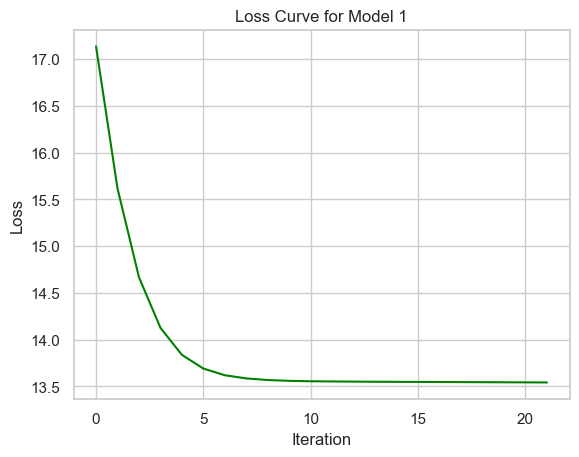

In [193]:
# Started off with sigmoid activation function, idea was to introduce non-linearity, enabling the model to learn complex patterns. 
# With a 15,5 hidden layer size striking balance between complexity and the risk of overfitting
# Also introduced a grid search to find best alpha
# result needed improving, need to think of more appropiate hyperparameters
sk_model1 = MLPRegressor(activation='logistic',   
                        solver='sgd',
                        batch_size='auto',
                        learning_rate_init=0.0001,
                        max_iter= 200,
                        random_state=42,
                        warm_start= False,
                        verbose=0,
                        hidden_layer_sizes=(15, 5,),
                        alpha=0.01,
                        early_stopping=True
                         )

sk_model1.fit(X_train_preprocessed, y_train)
loss_curve = sk_model1.loss_curve_


loss_curve2 = sk_model1.loss_curve_
plt.plot(loss_curve2, color="green")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss Curve for Model 1")
plt.show()


In [ ]:
alpha_values = [0.0001, 0.001, 0.01, 0.1]

# Create a dictionary to set up the grid for grid search
param_grid = {
    'alpha': alpha_values
}

# Grid search for sk_model2
grid_search_sk_model2 = GridSearchCV(estimator=sk_model1, param_grid=param_grid, 
                                     scoring='neg_mean_squared_error', 
                                     cv=5, 
                                     verbose=1)

# Perform grid search
grid_search_sk_model2.fit(X_train_preprocessed, y_train)

# Store the best parameters for nn_model2
best_params_sk_model2 = grid_search_sk_model2.best_params_

# Print the best parameters found for nn_model2
print("Best parameters for sk_model2:", best_params_sk_model2)


Fitting 5 folds for each of 4 candidates, totalling 20 fits


c:\Users\Edward Monbiot\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Edward Monbiot\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Edward Monbiot\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Edward Monbiot\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters for sk_model2: {'alpha': 0.0001}


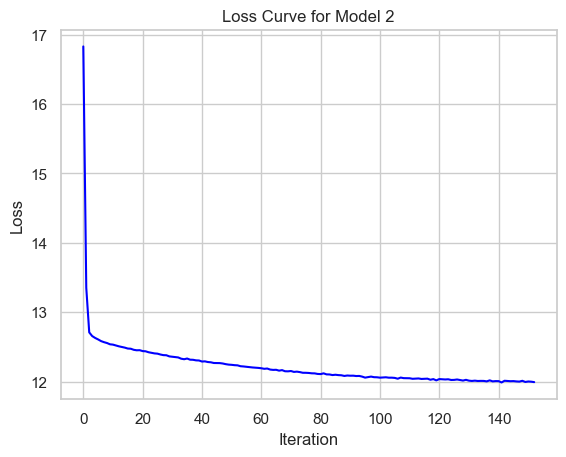

In [198]:
# This model gave me the best NN Kaggle Score
# second model, used ReLU (Rectified Linear Unit) activation function, popular in NN due to its simplicity and efficiency
# Adam solver is known for being effective on large datasets and handling sparse gradients well.
# Chose a small learning rate (0.01) to ensure more precise adjustments to weights, based on validation performance
# Set warm_start to True, which allowsfit() to continue learning from where it left off, which can be useful for iterative model tuning
# Set early_stopping=False to let the model train for the full number of iterations, when I set early stopping to True it prematurely halted training.
# Alpha chosen per grid search

sk_model2 = MLPRegressor(
    activation='relu',  #best activation function
    solver='adam', # found to be the best solver, tried all the others
    batch_size=64,
    learning_rate_init=0.001, 
    max_iter=200,
    random_state=42,
    warm_start=True,
    verbose=0,
    early_stopping=False,
    hidden_layer_sizes=(20, ), #one hidden layer size
    alpha=0.0001, #per cross validation 
)
sk_model2.fit(X_train_preprocessed, y_train)

# Plot the loss curve for the first model
loss_curve1 = sk_model2.loss_curve_
plt.plot(loss_curve1, color="blue")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss Curve for Model 2")
plt.show()

In [ ]:
alpha_values = [0.0001, 0.001, 0.01, 0.1]

# Create a dictionary to set up the grid for grid search
param_grid = {
    'alpha': alpha_values
}

# Grid search for nn_model1
grid_search_sk_model2 = GridSearchCV(estimator=sk_model1, param_grid=param_grid, 
                                     scoring='neg_mean_squared_error', 
                                     cv=5, 
                                     verbose=0)

# Perform grid search
grid_search_sk_model2.fit(X_train_preprocessed, y_train)

# Store the best parameters for nn_model1
best_params_sk_model2 = grid_search_sk_model2.best_params_

# Print the best parameters found for nn_model1
print("Best parameters for sk_model2:", best_params_sk_model2)


c:\Users\Edward Monbiot\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Edward Monbiot\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Edward Monbiot\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Edward Monbiot\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters for sk_model2: {'alpha': 0.0001}


### 3.2 SK Learn Basic Pipeline Model

I experimented with adding a pipeline to the SK learn models but niether made an improvement to the Kaggle score, this is likely to do with the fact that I used a similar pipeline in the preprocessing section

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import cross_val_score

# Define the KNN Imputer
knn_imputer = KNNImputer(n_neighbors=5, weights='distance')

# Feature selection using SelectKBest with f_regression as the score function
# You can choose `k` as the number of top features to select
select_k_best = SelectKBest(f_regression, k='all')

# Define the MLPRegressor with your desired hyperparameters
mlp_regressor = MLPRegressor(
    activation='identity', 
    solver='adam',
    batch_size=50,
    learning_rate_init=0.0001,
    max_iter=140,
    random_state=42,
    warm_start=True,
    verbose=0,
    early_stopping=False,
    hidden_layer_sizes=(50, 40, 20, 30, 10),
    alpha=0.1,
)

# Create the pipeline
pipeline_basic_NN = Pipeline([
    ('imputer', knn_imputer),
    ('feature_selection', select_k_best),
    ('nn', mlp_regressor)
])

In [ ]:
# Fit the pipeline
pipeline_basic_NN.fit(X_train_preprocessed, y_train)

# To evaluate the model, you can use cross-validation
scores = cross_val_score(pipeline_basic_NN, X_train_preprocessed, y_train, cv=5)

print(f"Cross-validation scores: {scores}")
print(f"Mean CV score: {scores.mean()}")

# To plot the loss curve, you'll need to access the MLPRegressor object within the pipeline
loss_curve = pipeline_basic_NN.named_steps['nn'].loss_curve_
plt.plot(loss_curve, color="red")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss Curve for Model within Simple Pipeline")
plt.show()

c:\Users\Edward Monbiot\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
c:\Users\Edward Monbiot\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


### 3.3 SK Learn Complex Pipeline Model

In [ ]:
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline


# Define the pipeline steps
pipeline_basic_NN = Pipeline(
    steps=[
        ("imputer", KNNImputer(n_neighbors=5, weights='distance')),
        ("selector", SelectKBest(f_regression, k='all')),  # Use 'all' or adjust k as needed
        ("regressor", MLPRegressor(activation='identity',
                    solver='adam',
                    batch_size=50,
                    learning_rate_init=0.0001,
                    max_iter=140,
                    random_state=42,
                    warm_start=True,
                    verbose=0,
                    early_stopping=False,
                    hidden_layer_sizes=(50, 40, 20, 30, 10,),
                    alpha=0.1))
    ]
)

# Define the parameter grid
param_grid_NN = {
    "selector__k": [10, 'all'],  
    "imputer__n_neighbors": [5, 10],  
    "imputer__weights": ['uniform', 'distance'], 
    "regressor__alpha": [0.1, 0.01],  # Example values for alpha
    
}


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END imputer__n_neighbors=5, imputer__weights=uniform, regressor__alpha=0.1, selector__k=10;, score=-23.768 total time=  20.0s
[CV 2/5] END imputer__n_neighbors=5, imputer__weights=uniform, regressor__alpha=0.1, selector__k=10;, score=-27.852 total time= 1.0min
[CV 3/5] END imputer__n_neighbors=5, imputer__weights=uniform, regressor__alpha=0.1, selector__k=10;, score=-23.308 total time=  36.2s
[CV 4/5] END imputer__n_neighbors=5, imputer__weights=uniform, regressor__alpha=0.1, selector__k=10;, score=-24.714 total time=  48.2s
[CV 5/5] END imputer__n_neighbors=5, imputer__weights=uniform, regressor__alpha=0.1, selector__k=10;, score=-28.029 total time=  24.3s
[CV 1/5] END imputer__n_neighbors=5, imputer__weights=uniform, regressor__alpha=0.1, selector__k=all;, score=-23.768 total time=  27.9s
[CV 2/5] END imputer__n_neighbors=5, imputer__weights=uniform, regressor__alpha=0.1, selector__k=all;, score=-27.852 total time=

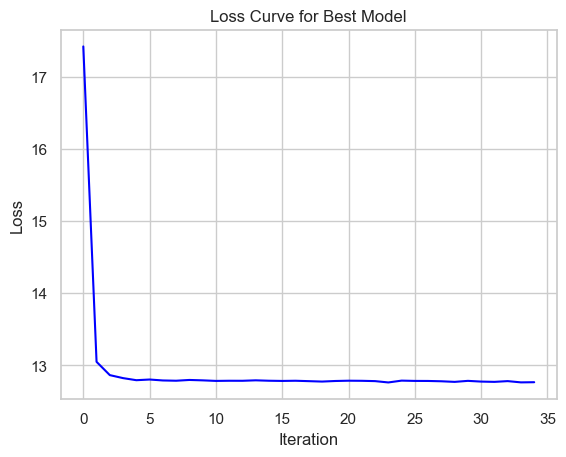

Best parameters: {'imputer__n_neighbors': 5, 'imputer__weights': 'uniform', 'regressor__alpha': 0.1, 'selector__k': 10}
Best score: 25.534259943299677


In [ ]:
# Set up the GridSearchCV object
SK_GRID_NN = GridSearchCV(pipeline_basic_NN, param_grid=param_grid_NN, scoring='neg_mean_squared_error', cv=5, verbose=3)
SK_GRID_NN.fit(X_train_preprocessed, y_train)  # Note: Use your preprocessed data here

# Access the best model and its loss curve
best_model = SK_GRID_NN.best_estimator_.named_steps["regressor"]
loss_curve = best_model.loss_curve_

# Plot the loss curve for the best model
plt.plot(loss_curve, color="blue")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss Curve for Best Model")
plt.show()

# Print best parameters and score
print('Best parameters:', SK_GRID_NN.best_params_)
print('Best score:', -SK_GRID_NN.best_score_)  # Convert from negative MSE to positive MSE

In [ ]:
# Accessing the loss_ attribute
best_model = SK_GRID_NN.best_estimator_.named_steps["regressor"]

best_params = SK_GRID_NN.best_params_

print('Loss:', best_model.loss_)
print('best parameters:', SK_GRID_NN.best_params_)
print('best score:', SK_GRID_NN.best_score_)

# Retrieve the best estimator from the grid search
best_pipeline = SK_GRID_NN.best_estimator_
print(best_pipeline)

Loss: 12.766877345069533
best parameters: {'imputer__n_neighbors': 5, 'imputer__weights': 'uniform', 'regressor__alpha': 0.1, 'selector__k': 10}
best score: -25.534259943299677
Pipeline(steps=[('imputer', KNNImputer()),
                ('selector',
                 SelectKBest(score_func=<function f_regression at 0x000002D4382142C0>)),
                ('regressor',
                 MLPRegressor(activation='identity', alpha=0.1, batch_size=50,
                              hidden_layer_sizes=(50, 40, 20, 30, 10),
                              learning_rate_init=0.0001, max_iter=140,
                              random_state=42, verbose=0, warm_start=True))])


<a id='section4'></a>
# Section 4 Neural Network Models - Keras

### 4.1 Model Early Stopping 

In [207]:
from sklearn.impute import KNNImputer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import initializers

In [208]:
# Initialize the KNNImputer
#knn_imputer = KNNImputer(n_neighbors=5, weights='distance')

# Fit and transform X_train and X_test
#X_train_imputed = knn_imputer.fit_transform(X_train_preprocessed)
#X_test_imputed = knn_imputer.transform(X_test_preprocessed)

X_train_imputed = X_train_preprocessed
X_test_imputed = X_test_preprocessed



Epoch 1/128

229/229 [==============================] - 4s 6ms/step - loss: 29.1158 - val_loss: 27.1569
Epoch 2/128
229/229 [==============================] - 1s 4ms/step - loss: 25.5592 - val_loss: 26.3927
Epoch 3/128
229/229 [==============================] - 1s 4ms/step - loss: 24.9560 - val_loss: 26.5013
Epoch 4/128
229/229 [==============================] - 1s 5ms/step - loss: 24.6661 - val_loss: 26.4070
Epoch 5/128
229/229 [==============================] - 1s 4ms/step - loss: 24.4076 - val_loss: 26.0445
Epoch 6/128
229/229 [==============================] - 1s 5ms/step - loss: 24.3568 - val_loss: 26.1349
Epoch 7/128
229/229 [==============================] - 1s 4ms/step - loss: 24.2229 - val_loss: 26.3209
Epoch 8/128
229/229 [==============================] - 1s 4ms/step - loss: 24.0271 - val_loss: 26.2723
Epoch 9/128
229/229 [==============================] - 1s 4ms/step - loss: 23.9630 - val_loss: 26.1646
Epoch 10/128
229/229 [==============================] - 1s 6ms/step - 

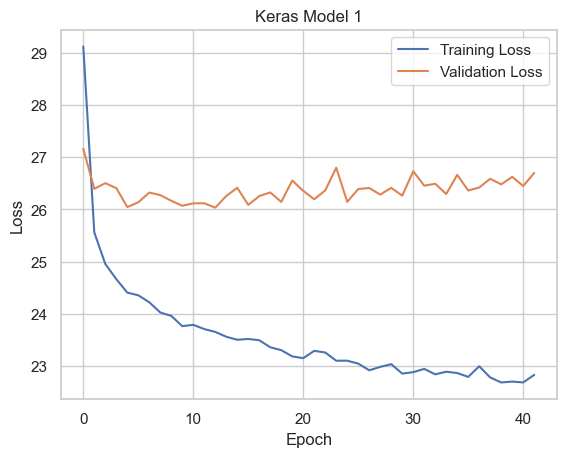

In [209]:
#first and second dense layers with 64 neurons with ReLU activation, 'HeNormal' initializer is also used for layers with ReLU activation. 
#output layer defined with single neuron with linear activation, layer is crucial as it determines how the model's predictions are formatted and interpreted.
#earlyStopping Callback: Monitors the 'loss' metric and will stop training if it doesn't improve after 3 epochs 

# Define the model
k_model1 = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_imputed.shape[1],), kernel_initializer=HeNormal()),
    Dense(64, activation='relu', kernel_initializer=HeNormal()),
    Dense(1, activation='linear')  # Assuming it's a regression problem
])

# Compile the model
k_model1.compile(optimizer='adam', loss='mse')

# Define the EarlyStopping callback
early_stopping_callback = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

# Fit the model
history = k_model1.fit(X_train_imputed, y_train,
                    batch_size=64,
                    epochs=128,
                    validation_split=0.3, #30% of your training data is used as validation data during the training process
                    callbacks=[early_stopping_callback])

# Plotting the loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Keras Model 1')
plt.legend()
plt.show()


Training loss has been decreasing over time, which indicates that the model is learning from the training data. The validation loss is higher than the training loss and seems to fluctuate, which might suggest that the model could be overfitting to the training data or that there might be some noise in the validation data.

### 4.2 Early Stopping

Epoch 1/128
229/229 [==============================] - 7s 10ms/step - loss: 31.0433 - val_loss: 26.8453
Epoch 2/128
229/229 [==============================] - 2s 8ms/step - loss: 26.0452 - val_loss: 26.1355
Epoch 3/128
229/229 [==============================] - 2s 10ms/step - loss: 25.5794 - val_loss: 26.2818
Epoch 4/128
229/229 [==============================] - 2s 9ms/step - loss: 25.8452 - val_loss: 26.1674
Epoch 5/128
229/229 [==============================] - 2s 8ms/step - loss: 25.5456 - val_loss: 26.1967
Epoch 6/128
229/229 [==============================] - 1s 5ms/step - loss: 25.1106 - val_loss: 26.0902
Epoch 7/128
229/229 [==============================] - 1s 6ms/step - loss: 25.2514 - val_loss: 26.1846
Epoch 8/128
229/229 [==============================] - 1s 5ms/step - loss: 25.2665 - val_loss: 25.9841
Epoch 9/128
229/229 [==============================] - 1s 5ms/step - loss: 25.0900 - val_loss: 26.1256
Epoch 10/128
229/229 [==============================] - 1s 5ms/step - l

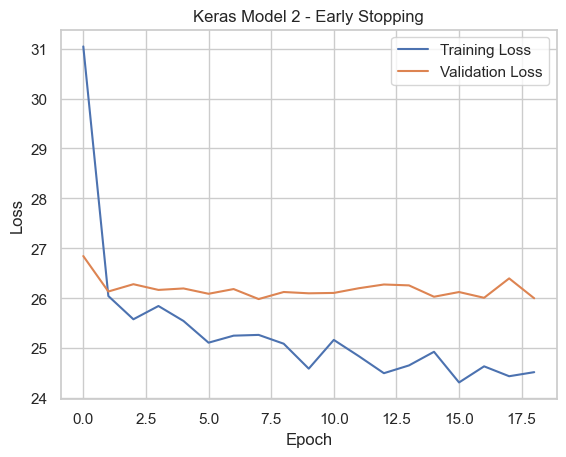

In [210]:
#k_model incorporates Dropout layers with a 20% dropout rate after each of the first two dense layers. 
#Helps in preventing overfitting by randomly deactivating a fraction of neurons during training
#bias initializers are  set to zeros in this model, whereas in the earlier model


# Define the model with Dropout layers
k_model2 = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_imputed.shape[1],),
          kernel_initializer=initializers.HeNormal(),
          bias_initializer=initializers.Zeros()),
    Dropout(0.2),  # Adding dropout with a dropout rate of 0.2 (20%)
    Dense(64, activation='relu', kernel_initializer=initializers.HeNormal(),
          bias_initializer=initializers.Zeros()),
    Dropout(0.2),  # Adding dropout with a dropout rate of 0.2 (20%)
    Dense(1, activation='linear')  # Linear activation for regression
])

# Compile the model
k_model2.compile(optimizer='adam', loss='mse')

# Define the EarlyStopping callback
early_stopping_callback = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

# Train the model with the EarlyStopping callback
history = k_model2.fit(X_train_imputed, y_train,
                    batch_size=64,
                    epochs=128,
                    validation_split=0.3,
                    callbacks=[early_stopping_callback])

# Plotting the loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Keras Model 2 - Early Stopping')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Gap Between Training and Validation Loss: The gap between the training and validation loss seems to have narrowed, suggesting that dropout has helped in mitigating overfitting. This is a positive sign that your model is generalizing better to unseen data.

Smoothing of the Validation Loss: The validation loss appears to fluctuate less compared to the previous graph. This can indicate that your model is becoming more stable and is not as sensitive to small variations in the training data.

Trends: Both training and validation losses are trending downwards. The training loss is decreasing, which is expected, and the validation loss, while higher, does not show signs of increasing, which is a common indicator of overfitting.

With regularization 

### 4.3 L2 Regularization

Epoch 1/128
229/229 [==============================] - 5s 8ms/step - loss: 33.3150 - val_loss: 29.3649
Epoch 2/128
229/229 [==============================] - 2s 7ms/step - loss: 29.3486 - val_loss: 29.3448
Epoch 3/128
229/229 [==============================] - 1s 5ms/step - loss: 28.5758 - val_loss: 28.7889
Epoch 4/128
229/229 [==============================] - 1s 6ms/step - loss: 28.3415 - val_loss: 28.9206
Epoch 5/128
229/229 [==============================] - 2s 8ms/step - loss: 28.1286 - val_loss: 28.8171
Epoch 6/128
229/229 [==============================] - 1s 6ms/step - loss: 28.0399 - val_loss: 28.2531
Epoch 7/128
229/229 [==============================] - 3s 11ms/step - loss: 27.5261 - val_loss: 28.2148
Epoch 8/128
229/229 [==============================] - 2s 8ms/step - loss: 27.0977 - val_loss: 28.2777
Epoch 9/128
229/229 [==============================] - 1s 4ms/step - loss: 27.0714 - val_loss: 28.0806
Epoch 10/128
229/229 [==============================] - 1s 5ms/step - lo

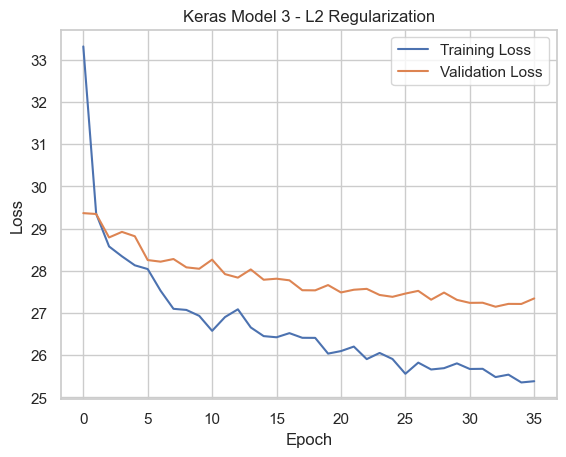

In [211]:
#k_model3 integrates L2 regularization into all its layers
#It applies a penalty to both kernel and bias weights to mitigate overfitting by discouraging large weights in the model. 
#monitoring metric for the EarlyStopping callback has been switched from 'loss' to 'val_loss', it now focues on improvement in the model's performance on the validation set.

from tensorflow.keras import initializers, regularizers
# Define the model with L2 regularization
k_model3 = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_imputed.shape[1],),
          kernel_initializer=initializers.HeNormal(),
          bias_initializer=initializers.Zeros(),
          kernel_regularizer=regularizers.l2(0.01),  # L2 regularization
          bias_regularizer=regularizers.l2(0.01)),
    Dropout(0.2),
    Dense(64, activation='relu', kernel_initializer=initializers.HeNormal(),
          bias_initializer=initializers.Zeros(),
          kernel_regularizer=regularizers.l2(0.01),  # L2 regularization
          bias_regularizer=regularizers.l2(0.01)),
    Dropout(0.2),
    Dense(1, activation='linear', kernel_regularizer=regularizers.l2(0.01),  # L2 regularization
          bias_regularizer=regularizers.l2(0.01))
])

# Compile the model
k_model3.compile(optimizer='adam', loss='mse')

# Define the EarlyStopping callback
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with the EarlyStopping callback
history = k_model3.fit(X_train_imputed, y_train,
                    batch_size=64,
                    epochs=128,
                    validation_split=0.3,
                    callbacks=[early_stopping_callback])

# Plotting the loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Keras Model 3 - L2 Regularization')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

The training loss decreases sharply initially and then gradually flattens out, indicating the model is learning and stabilizing over time. The validation loss follows a similar trend but lies above the training loss, which is expected due to the model's familiarity with the training data. There's no significant gap between the two, suggesting that overfitting is not a major concern, possibly due to the effectiveness of L2 regularization

### 4.4 Keras Exponential Activation

Epoch 1/150
262/262 [==============================] - 6s 8ms/step - loss: 84030347280384.0000 - mae: 73954.9766 - mse: 84030347280384.0000 - val_loss: 12423158784.0000 - val_mae: 2059.4487 - val_mse: 12423158784.0000
Epoch 2/150
262/262 [==============================] - 2s 9ms/step - loss: 938965598208.0000 - mae: 9244.9873 - mse: 938965598208.0000 - val_loss: 32910487552.0000 - val_mae: 3781.4080 - val_mse: 32910487552.0000
Epoch 3/150
262/262 [==============================] - 2s 9ms/step - loss: 8590477312.0000 - mae: 1589.8748 - mse: 8590477312.0000 - val_loss: 4769053184.0000 - val_mae: 1507.6874 - val_mse: 4769053184.0000
Epoch 4/150
262/262 [==============================] - 2s 9ms/step - loss: 659811392.0000 - mae: 443.7231 - mse: 659811392.0000 - val_loss: 8470153216.0000 - val_mae: 2030.6921 - val_mse: 8470153216.0000
Epoch 5/150
262/262 [==============================] - 1s 5ms/step - loss: 192688288.0000 - mae: 319.7485 - mse: 192688288.0000 - val_loss: 3728510720.0000 - 

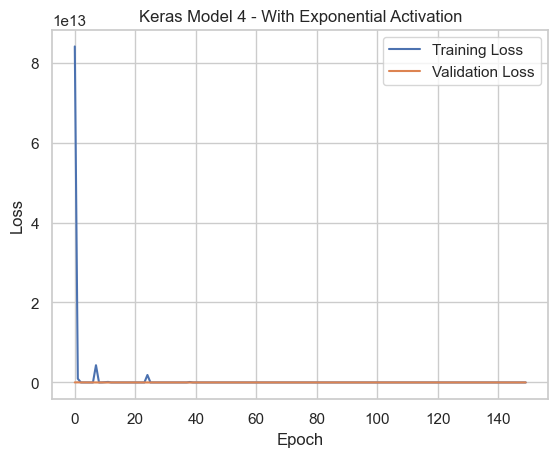

In [232]:
from keras import regularizers
from keras.layers import Dense, BatchNormalization, Dropout
#In the k_model4, the first Dense layer has 16 neurons and uses the ReLU activation function. The last Dense layer has a single neuron with an exponential activation function
#batch normalization, and dropout to prevent overfitting, and it's compiled with the Adam optimizer for training.

# Define the simplified model with a single hidden layer and L2 regularization
k_model4 = Sequential([
    Dense(16, activation='relu', input_shape=(X_train_preprocessed.shape[1],),
          kernel_initializer=initializers.HeNormal(),
          bias_initializer=initializers.Zeros(),
          kernel_regularizer=regularizers.l1_l2(l1=0.0001, l2=0.00001)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(1, activation='exponential')  # Output layer for regression
])

# Compile the model
k_model4.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])

# Train the model
history = k_model4.fit(X_train_imputed, y_train,
                    batch_size=64,
                    epochs=150,
                    validation_split=0.2)

# Plotting the loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Keras Model 4 - With Exponential Activation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

The training loss decreases sharply and then plateaus, which indicates that the model is learning from the training data and then stabilizing. The validation loss, while initially higher, converges closely with the training loss, suggesting that the model is generalizing well and not overfitting significantly to the training data.

<a id='section5'></a>
# Section 5 Kaggle Submission 

In [226]:
# Make probability predictions on the test set
y_pred_best_nn =  k_model4.predict(X_test_preprocessed) #choose  model to output predictions

164/164 [==============================] - 1s 3ms/step


In [227]:
# Flatten the predictions to 1D if they're not already
y_pred_best_nn_flat = y_pred_best_nn.flatten()

In [228]:
len(y_pred_best_nn_flat) # check the length of the predictions and make sure that it matches the length of the test data set 5221

5221

In [229]:
# Add predictions to the df_output DataFrame
df_output['LOS'] = y_pred_best_nn_flat

In [230]:
# Create a new DataFrame with just 'icustay_id' and 'LOS' for submission
kaggle_submit_df = df_output[['icustay_id', 'LOS']]

In [231]:
# Save the DataFrame to a CSV file for submission
kaggle_submit_df.to_csv('nn_kaggle_submission.csv', index=False)